<a href="https://colab.research.google.com/github/patrikgerard/Uncovering-Narratives/blob/main/Cross_Temporal_Story_and_Narrative_Evolution_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Narrative Detection and Evolution

In this notebook, we introduce the OnlineAgglomerative class, the MacroNarrative class, explain their components, and show how to use them with both an illustrative toy case and a data-intensive use-case.

### Imports

In [ ]:
!pip install deep_translator
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.5 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch.nn.functional import cosine_similarity
import numpy as np
import copy
import plotly.express as px
import plotly.graph_objs as go
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from collections import defaultdict
from math import log2
from deep_translator import GoogleTranslator
import time
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # This turns off chained assignment warnings globally
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
import time
from scipy.spatial.distance import cosine
from scipy.spatial.distance import cdist
from scipy.spatial.distance import cosine, euclidean
from scipy.stats import t
from tqdm.auto import tqdm
import concurrent.futures
import os
from datetime import datetime, timedelta
import pickle
from collections import deque
from tqdm.auto import tqdm

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

##The OnlineAgglomerative Class

###Here we provide a high-level overview of how the class works
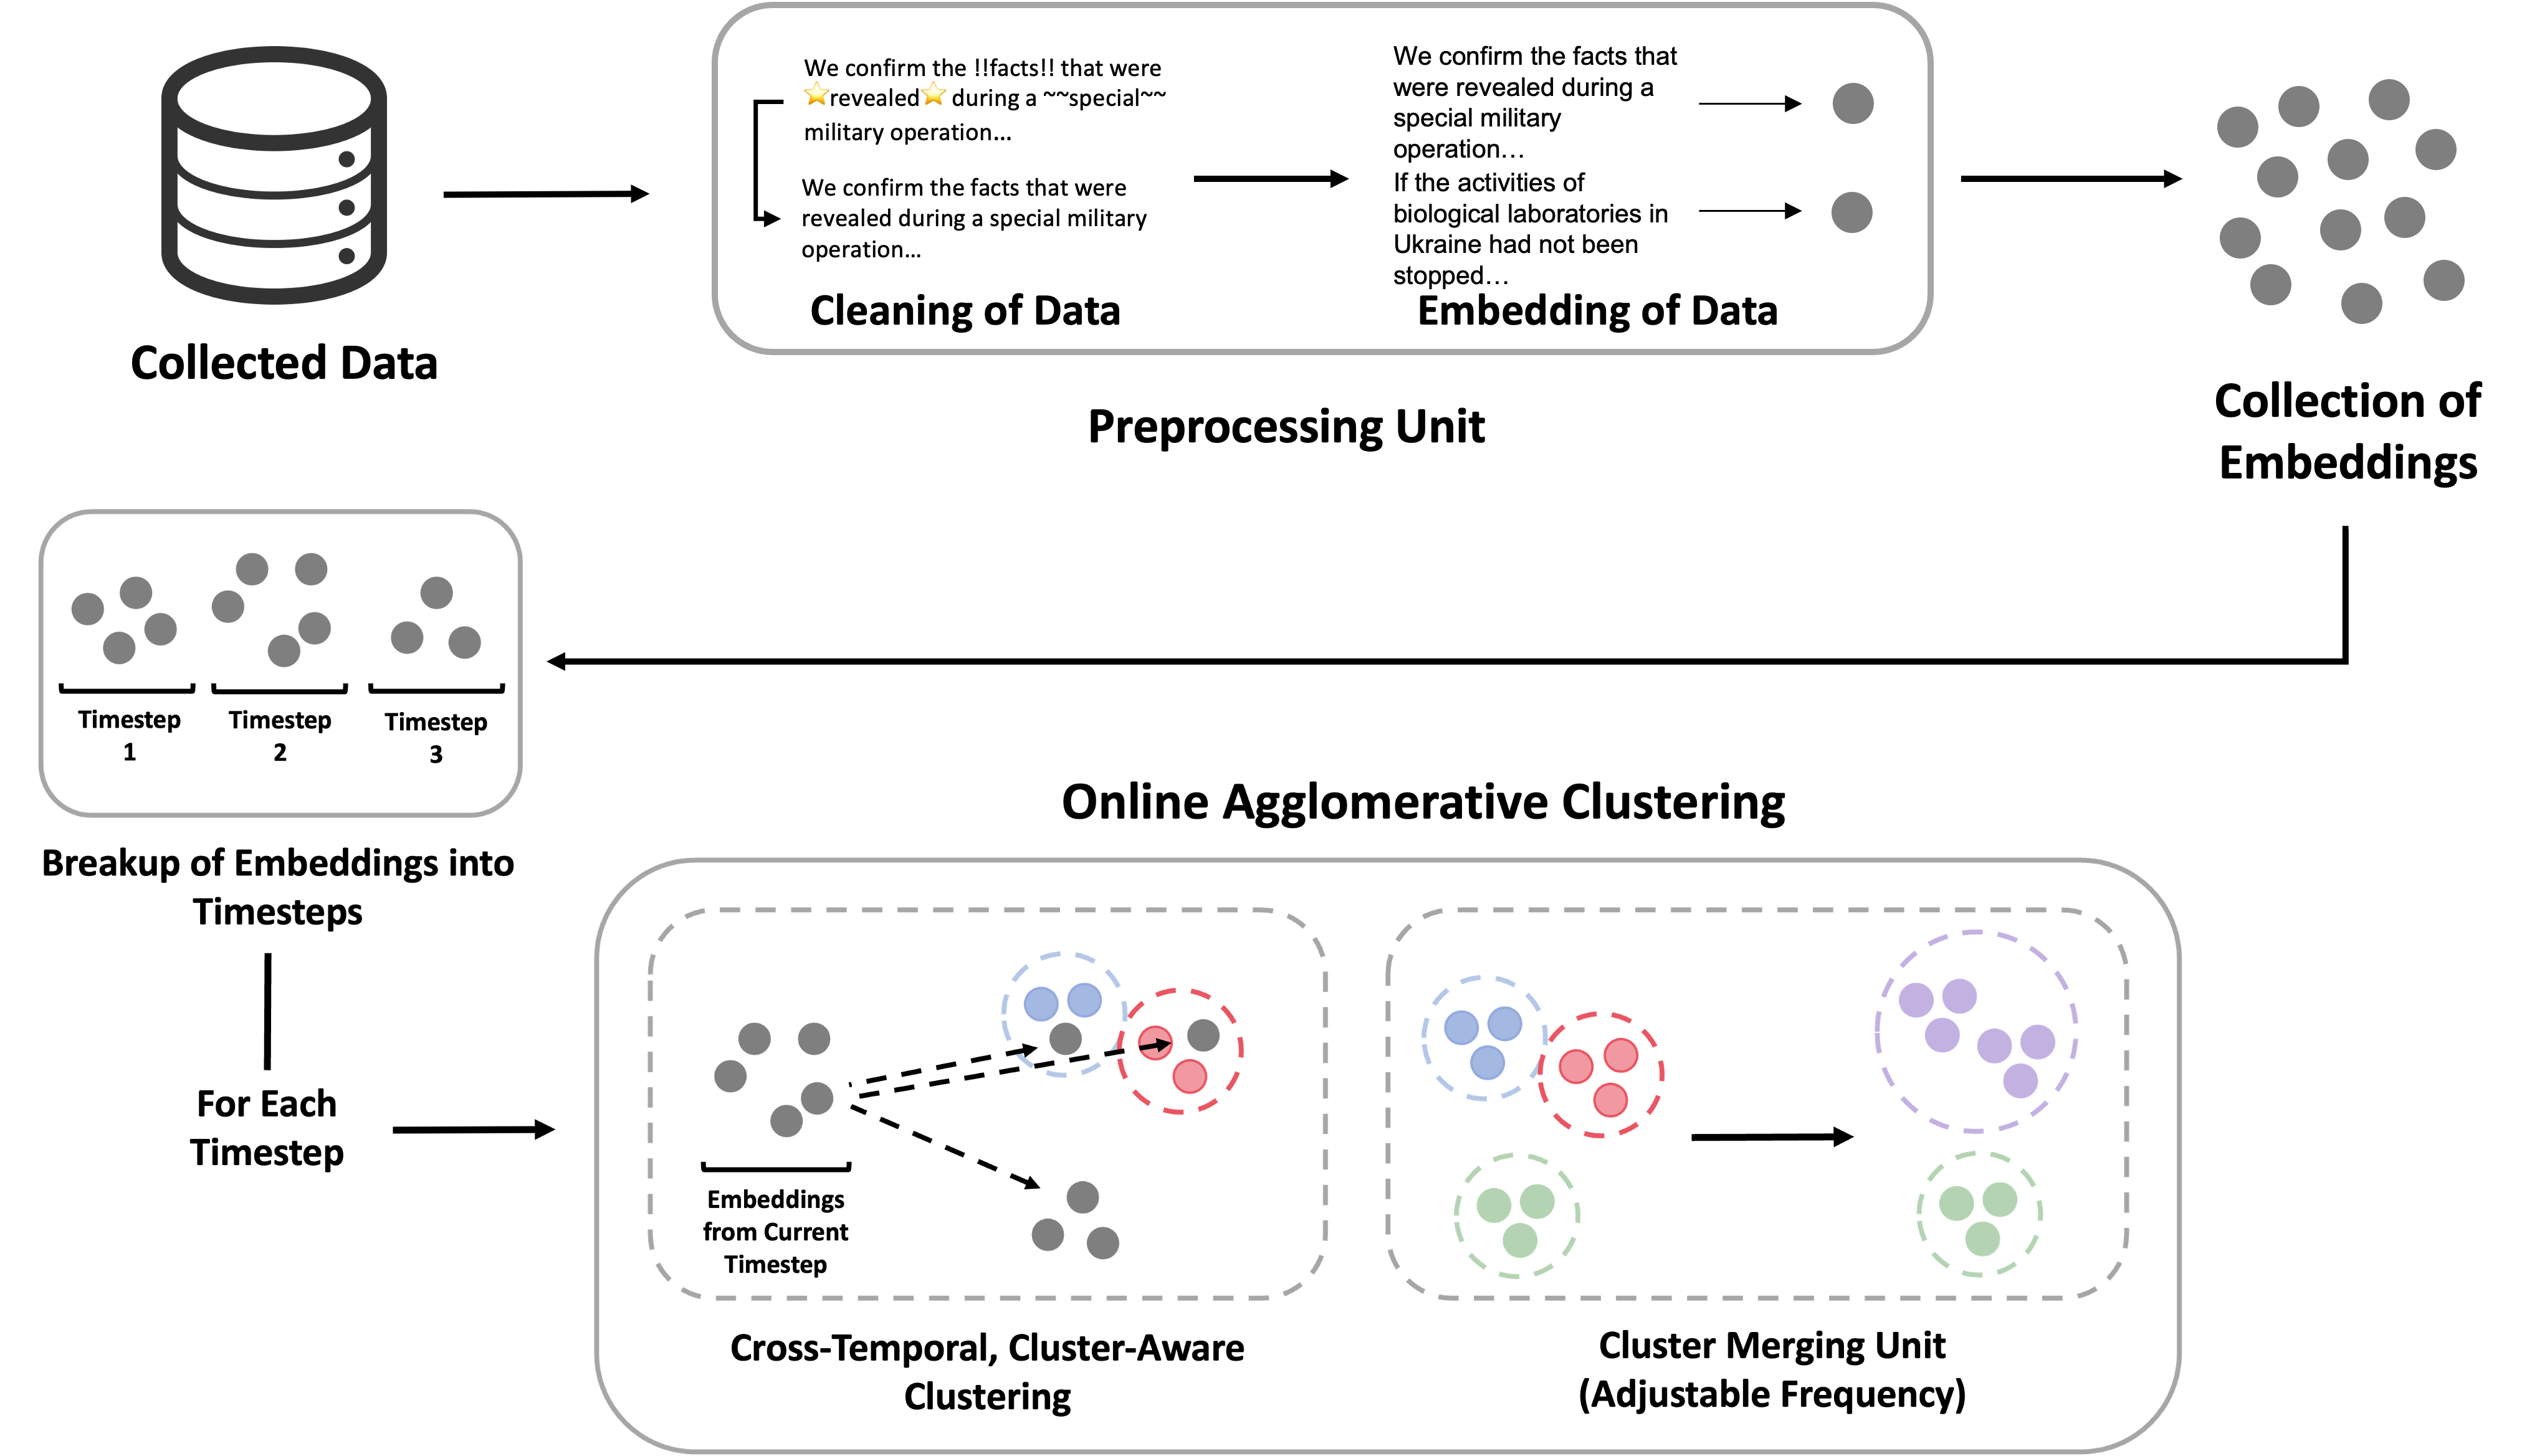
1. **Data Collection**:
    - At the beginning of the pipeline, raw data is collected. This data could come from various sources, allowing the flexibility for users to plug in different data retrieval modules depending on the source.
2. **Preprocessing:**
	- **Text Cleaning and Preparation**:
		- Text data undergoes initial cleaning, which can include cleaning (removing noise like irrelevant symbols or stop words), normalization (like stemming or lemmatization), and separation into individual texts that can be embedded. Again, we note that this step is up to the user, allowing customization for language-specific preprocessing or domain-specific requirements.
	- **Embedding of Texts**:
	    - Cleaned texts are transformed into embeddings. The user can choose which model to use to generate these embeddings.
3. **Breakup of Embeddings**:
	- Embeddings are then broken up into the desired timesteps. The user, once again, chooses these timesteps.
4. **Online Agglomerative Clustering**:
    - The embeddings are fed into an Online Agglomerative Clustering algorithm, which incrementally forms clusters as new data arrives. The clustering across timesteps allows for the tracking of how narratives shift or how new topics emerge. This step is adaptable to different clustering parameters and similarity thresholds.
    - The algorithm clusters data not only within individual timeframes but also across them, linking clusters from different timestamps to track the progression or changes of the narratives over time.

In [ ]:
class OnlineAgglomerative:
    def __init__(self, similarity_threshold, distance_type='cosine', cluster_combination_metric='f_score'):
        self.similarity_threshold = similarity_threshold
        self.distance_type = distance_type
        self.verbose = False
        self.clusters = []
        self.centroids = []
        self.silhouette_scores = []
        self.outliers = []
        self.cluster_labels = []
        self.cluster_radii = []
        self.cluster_point_counts = []
        self.farthest_centroid_distances = []
        self.threshold_cluster = 5
        self._n_threads = os.cpu_count()
        self.cluster_history = {}  # Format: {cluster_id: {'created': timestep, 'consumed': [(cluster_id, timestep)]}}
        self.consumed_clusters = {}  # Format: {consumed_cluster_id: (merged_into_cluster_id, timestep)}
        self.history_window = 4
        self.centroid_history = {}  # Format: {cluster_id: [centroid_timestep_1, centroid_timestep_2, ...]}
        self.radius_history = {}
        self.cluster_metrics = {}
        self.cluster_combination_metric = cluster_combination_metric

        self.current_timestep = 0
        self.filtered_clusters = set()





    def _mini_fit(self, embeddings):
        """
        Performs a mini clustering operation on a subset of embeddings; this is typically used for processing a batch of new data
        or outliers. This method applies hierarchical clustering to these embeddings based on similarity measures.

        Steps:
        1. Calculates a similarity matrix for the given embeddings to measure the similarity between each pair of embeddings.
        2. Converts the similarity matrix into a distance matrix (1 - similarity) to use distance-based clustering.
        3. Applies hierarchical clustering on the distance matrix using an average linkage method, grouping embeddings into clusters based on a defined distance threshold related to the similarity threshold.
        4. For each newly formed cluster, calculates the centroid by averaging the embeddings within the cluster.
        5. Updates the cluster's statistics, including the centroid, maximum distance from the centroid (radius), and the number of points within the cluster (this information is used later).


        Parameters:
        - embeddings: A subset of embeddings to be clustered, this is typically outliers.

        Returns:
        - clusters: The cluster assignments for the provided embeddings.
        - new_centroids: The centroids of the newly formed clusters.
        """
        # Calculate cosine similarity and distance matrix
        distance_matrix = None
        if self.distance_type == 'cosine':
          cosine_sim_matrix = cosine_similarity(embeddings)
          distance_matrix = np.clip(1 - cosine_sim_matrix, 0, None)
        if self.distance_type == 'euclidean':
          euclidean_dist_matrix = euclidean_distances(embeddings)
          distance_matrix = euclidean_dist_matrix


        similarity_threshold = self.similarity_threshold
        np.fill_diagonal(distance_matrix, 0)

        # Perform hierarchical clustering
        Z = linkage(squareform(distance_matrix), method='average')
        distance_threshold = 1 - similarity_threshold
        clusters = fcluster(Z, t=distance_threshold, criterion='distance')

        # Initialize variables for new clusters
        new_cluster_labels = np.unique(clusters)
        new_centroids = []
        new_cluster_radii = []
        new_cluster_point_counts = []
        new_farthest_centroid_distances = []

        # Compute the centroid of each new cluster and other statistics
        for label in new_cluster_labels:
            cluster_points = embeddings[clusters == label]
            centroid = cluster_points.mean(axis=0)
            new_centroids.append(centroid)

            # Calculate distances from the centroid to all points in the cluster
            distances = np.linalg.norm(cluster_points - centroid, axis=1)

            # Update the farthest distance, radius, and count for each new cluster
            new_farthest_centroid_distances.append(distances.max())
            new_cluster_radii.append(distances.max())
            new_cluster_point_counts.append(len(cluster_points))

        # Append the new cluster information to the existing attributes
        max_existing_label = max(self.cluster_labels, default=-1)
        new_cluster_ids = [i + max_existing_label + 1 for i in new_cluster_labels]

        self.centroids = np.concatenate((self.centroids, new_centroids))
        self.cluster_labels = np.concatenate((self.cluster_labels, new_cluster_ids))
        self.cluster_radii = np.concatenate((self.cluster_radii, np.array(new_cluster_radii)))
        self.cluster_point_counts = np.concatenate((self.cluster_point_counts, np.array(new_cluster_point_counts)))
        self.farthest_centroid_distances = np.concatenate((self.farthest_centroid_distances, np.array(new_farthest_centroid_distances)))
        return clusters, new_centroids



    def incremental_fit(self, new_embeddings, outlier_threshold, batch_size=100):
        """
        Processes new embeddings incrementally in specified batch sizes to update and refine the clustering model over time.

        Steps:
        1. Divides the incoming embeddings into batches (we do this to manage memory usage and computational load efficiently).
        2. For each batch, we asses the embeddings individually to determine if they are outliers based on the specified threshold.
        3. Non-outlier embeddings are integrated directly into the nearest existing cluster, then we update the cluster's centroid, radius, and point count.
        4. Outliers are collected until their number reaches the outlier threshold, at which point they are clustered together using a mini fit process -- this performs hierarchical clustering and
        potentially forms new clusters or allows them to be absorded into existing clusters.
        5. After batches, clusters may be combined to refine the clustering model further.

        Parameters:
        - new_embeddings: The new data points to be clustered.
        - outlier_threshold: The number of outliers that triggers an attempt to cluster these outliers.
        - batch_size: The number of embeddings processed in a single batch.

        Returns:
        None
        """

        start_time = time.time()
        outlier_absorption = False
        cluster_combination = False


        # Process embeddings in batches
        for i in range(0, len(new_embeddings), batch_size):
            batch_embeddings = new_embeddings[i:i + batch_size]

            current_batch_number = i // batch_size + 1

            # Calculate total number of batches
            # Adding 1 to account for the last batch which might be smaller
            total_batches = (len(new_embeddings) + batch_size - 1) // batch_size

            print(f'Processing batch {current_batch_number} of {total_batches}')
            for x_insert in tqdm(batch_embeddings):
                is_outlier, nearest_cluster_idx = self.is_outlier(x_insert)

                if is_outlier:
                    # print('is outlier!')
                    self.outliers.append(x_insert)

                    if len(self.outliers) >= outlier_threshold:
                        outliers_array = np.array(self.outliers)
                        new_clusters, new_centroids = self._mini_fit(outliers_array)
                        self.outliers = []
                        cluster_combination = True
                else:
                    self._update_cluster_on_insert(x_insert, nearest_cluster_idx)

            # Update model at the end of each batch
            if cluster_combination:
                print('Combining Clusters...')
                try:
                    if self.combine_clusters():
                        cluster_combination = False
                except Exception as e:
                    print(f'Error combining clusters: {e}')

            # Optional: Absorb outliers after each batch if needed
            if outlier_absorption:
                print('Absorbing outliers...')
                try:
                    self.absorb_outliers()
                    outlier_absorption = False
                except Exception as e:
                    print(f'Error absorbing outliers: {e}')

        elapsed_time = time.time() - start_time

        for i, label in enumerate(self.cluster_labels):
            try:
                # Initialize history if not already present
                if label not in self.centroid_history:
                    self.centroid_history[label] = [(self.centroids[i], self.current_timestep)]
                else:
                    # Append to existing history
                    self.centroid_history[label].append((self.centroids[i], self.current_timestep))

                if label not in self.radius_history:
                    self.radius_history[label] = [(self.cluster_radii[i], self.current_timestep)]
                else:
                    # Append to existing history
                    self.radius_history[label].append((self.cluster_radii[i], self.current_timestep))
            except:
                pass

        self.calculate_cluster_metrics()
        self.current_timestep += 1
        print(f"Incremental clustering with batch processing took {elapsed_time:.2f} seconds")



    def fit(self, embeddings):
        """
        Performs the initial clustering on the entire set of embeddings using hierarchical clustering. This sets up
        the initial clustering model, establishing a baseline for future incremental updates.

        Steps:
        1. Computes a similarity matrix for the embeddings to evaluate the similarity between each pair.
        2. Transforms the similarity matrix into a distance matrix (1 - similarity) to apply distance-based clustering.
        3. Utilizes hierarchical clustering with an 'average' linkage method on the distance matrix, forming initial clusters based on a distance threshold that inversely relates to the similarity threshold.
        4. Calculates the centroid for each cluster by averaging the embeddings within the cluster.
        5. Determines the radius (maximum distance from the centroid), point count, and farthest centroid distance for each cluster to support outlier detection and cluster updates in future processing.
        6. Optionally calculates silhouette scores for each sample within the clusters to evaluate the clustering quality, which can inform subsequent clustering adjustments or model tuning.

        This foundational clustering provides a comprehensive view of the data's initial structure, allowing for incremental refinement as new data is introduced or as the data distribution evolves over time.

        Parameters:
        - embeddings: The complete set of embeddings to be clustered initially.

        Returns:
        None, but establishes the model's initial clustering structure, including centroids, cluster labels, and related metrics.
        """


        start_time = time.time()

        # Step 2: Hierarchical clustering

        distance_matrix = None
        if self.distance_type == 'cosine':
          cosine_sim_matrix = cosine_similarity(embeddings)
          distance_matrix = np.clip(1 - cosine_sim_matrix, 0, None)
        if self.distance_type == 'euclidean':
          euclidean_dist_matrix = euclidean_distances(embeddings)
          distance_matrix = euclidean_dist_matrix


        similarity_threshold = self.similarity_threshold
        np.fill_diagonal(distance_matrix, 0)

        # Perform hierarchical clustering
        Z = linkage(squareform(distance_matrix), method='average')
        distance_threshold = 1 - similarity_threshold
        clusters = fcluster(Z, t=distance_threshold, criterion='distance')
        self.clusters = clusters

        # Initialize lists to store cluster information
        self.cluster_labels = np.unique(clusters)
        self.cluster_radii = []
        self.cluster_point_counts = []
        self.farthest_centroid_distances = []

        # Compute the centroid of each cluster and other statistics
        for label in self.cluster_labels:
            cluster_points = embeddings[clusters == label]
            centroid = cluster_points.mean(axis=0)
            self.centroids.append(centroid)

            # Calculate distances from the centroid to all points in the cluster
            distances = np.linalg.norm(cluster_points - centroid, axis=1)

            # Update the farthest distance, radius, and count for each cluster
            self.farthest_centroid_distances.append(distances.max())
            self.cluster_radii.append(distances.max())
            self.cluster_point_counts.append(len(cluster_points))

        # Compute the silhouette scores for each sample
        self.silhouette_scores = silhouette_samples(distance_matrix, clusters, metric="precomputed")

        elapsed_time = time.time() - start_time
        print(f"Hierarchical clustering took {elapsed_time:.2f} seconds")


        for i, label in enumerate(self.cluster_labels):
            # Initialize history if not already present
            if label not in self.centroid_history:
                self.centroid_history[label] = [(self.centroids[i], self.current_timestep)]
            else:
                # Append to existing history
                self.centroid_history[label].append((self.centroids[i], self.current_timestep))

            if label not in self.radius_history:
                self.radius_history[label] = [(self.cluster_radii[i], self.current_timestep)]
            else:
                # Append to existing history
                self.radius_history[label].append((self.cluster_radii[i], self.current_timestep))

        self.calculate_cluster_metrics()
        self.current_timestep += 1



    def calculate_cluster_metrics(self):
        """
        Calculate and store cluster metrics based on their centroid and radius history.

        Iterates through each cluster's historical data to calculate changes in the centroid's position
        and the cluster's radius over the last two timesteps. Metrics calculated include the Euclidean
        distance between the last two centroids and the percentage change in radius.
        Metrics are stored as a dictionary within the cluster_metrics attribute of the object.
        Parameters:
        - None.

        Returns:
        - None.
        """

        for cluster_id in self.cluster_labels:
            centroid_history = [item[0] for item in self.centroid_history.get(cluster_id, [])]
            radius_history = [item[0] for item in self.radius_history.get(cluster_id, [])]
            if len(centroid_history) < 2 or len(radius_history) < 2:
                continue  # Skip if not enough data
            # Calculate metrics
            centroid_distance = np.linalg.norm(centroid_history[-1] - centroid_history[-2])
            radius_change = radius_history[-1] - radius_history[-2]
            percent_radius_change = (radius_change / radius_history[-2] * 100) if radius_history[-2] != 0 else float('inf')

            # Store metrics in the object
            self.cluster_metrics[cluster_id] = {
                "timestep": self.current_timestep,
                "centroid_distance": centroid_distance,
                "radius_change": radius_change,
                "percent_radius_change": percent_radius_change
            }



    def predict_single_embedding(self, embedding):
        """
        Determines the closest centroid to a given embedding based on the configured distance metric (cosine or euclidean).
        We use this for assigning a cluster to a new or isolated data point after the model has been trained.

        Steps:
        1. Calculates the distance between the given embedding and each of the existing cluster centroids using the specified distance metric.
        2. Identifies the nearest centroid by selecting the one with the smallest distance to the embedding.
        3. Returns the label of the nearest cluster along with the centroid vector itself.


        Parameters:
        - embedding: A single data point's embedding vector to classify into an existing cluster.

        Returns:
        - A tuple containing the label of the nearest cluster and the vector of the closest centroid.
        """
        # Calculate the distance to each cluster centroid
        if self.distance_type == 'cosine':
            distances = np.array([cosine(embedding, centroid) for centroid in self.centroids])
        elif self.distance_type == 'euclidean':
            distances = np.linalg.norm(self.centroids - embedding, axis=1)
        else:
            raise ValueError("Unsupported distance type. Use 'cosine' or 'euclidean'.")

        # Find the index of the nearest centroid
        nearest_centroid_idx = np.argmin(distances)
        return self.cluster_labels[nearest_centroid_idx], self.centroids[nearest_centroid_idx]

    def predict(self, X):
        """
        Predicts cluster labels and the closest centroids for a given set of embeddings (X).
        We use multithreading here to compute labels in parallel for large datasets.

        Steps:
        1. Computes similarities between the embeddings and existing cluster centroids.
        2. Transforms these similarities into distances (1 - similarity), as closer points have smaller distances.
        3. Identifies the closest centroid for each embedding based on the minimum distance (maximum similarity).
        4. Utilizes a ThreadPoolExecutor to distribute the computation across multiple threads, each handling a subset of the embeddings.
        5. Aggregates the results from all threads, forming a complete set of labels and closest centroids for the input data.

        Returns:
        - clusters: An array of the predicted cluster labels for each embedding.
        - closest_centroids: An array of the closest centroid vectors corresponding to each embedding's predicted cluster.
        """


        def compute_labels(start, end):
            # Calculate cosine similarity (values range from -1 to 1)
            similarities = cosine_similarity(X[start:end], self.centroids)

            # Convert similarities to distances (1 - similarity)
            # Closer points have smaller distances
            distances = 1 - similarities

            # Get the index of the centroid with the minimum distance (maximum similarity)
            return np.argmin(distances, axis=1)

        labels = np.empty(X.shape[0], dtype=int)
        closest_centroids = []
        clusters = []

        with concurrent.futures.ThreadPoolExecutor(max_workers=self._n_threads) as executor:
            futures = []
            # batch_size = len(X) // self._n_threads
            batch_size = max(len(X) // self._n_threads, 1)

            for i in range(0, len(X), batch_size):
                end = min(i + batch_size, len(X))
                futures.append(executor.submit(compute_labels, i, end))

            # Combine results from all threads
            for i, future in enumerate(futures):
                start = i * batch_size
                end = min(start + batch_size, len(X))
                labels[start:end] = future.result()

        for label in labels:
            closest_centroids.append(self.centroids[label])
            clusters.append(self.cluster_labels[label])


        return clusters, closest_centroids


    def _update_cluster_on_insert(self, x_insert, cluster_idx):
        """
        Updates the specified cluster with a new data point, recalculating the centroid, adjusting the cluster's radius,
        and incrementing the point count.

        Steps:
        1. Computes the new centroid by incorporating the new data point (x_insert) into the existing centroid calculation, accounting for the updated number of points within the cluster.
        2. Updates the internal representation of the centroid for the specified cluster to reflect the addition of the new point.
        3. Increments the point count for the cluster to include the new data point.
        4. Calculates the distance from the new centroid to the inserted data point. If this distance is greater than the current farthest distance recorded for the cluster, the farthest distance is updated to this new value, potentially adjusting the cluster's radius.
        5. If the cluster's history does not already contain an entry for the current timestep, it is updated to include the creation or modification of the cluster due to the insertion.

        Parameters:
        - x_insert: The embedding vector of the new data point to be inserted into the cluster.
        - cluster_idx: The index of the cluster being updated with the new data point.

        Returns:
        None, but modifies the model's state by updating the specified cluster's centroid, point count, and farthest distance metrics.
        """
        # Calculate the new centroid
        n_points = self.cluster_point_counts[cluster_idx]  # The current number of points in the cluster
        current_centroid = self.centroids[cluster_idx]
        new_centroid = (current_centroid * n_points + x_insert) / (n_points + 1)

        # Update the centroid in the class instance
        self.centroids[cluster_idx] = new_centroid

        # Update the number of points in the cluster
        self.cluster_point_counts[cluster_idx] = n_points + 1

        # Calculate the distance of the new point from the new centroid
        distance_to_new_point = np.linalg.norm(new_centroid - x_insert)

        # Update the farthest distance if the new point is farther than the current farthest
        if distance_to_new_point > self.farthest_centroid_distances[cluster_idx]:
            self.farthest_centroid_distances[cluster_idx] = distance_to_new_point

        if cluster_idx not in self.cluster_history:
            self.cluster_history[cluster_idx] = {'created': self.current_timestep, 'consumed': []}



    def is_outlier(self, x_insert, alpha=0.05):

        """
        Evaluates whether a given data point (x_insert) is an outlier relative to the existing clusters, based on its distance
        to the nearest cluster's centroid and the cluster's radius. Utilizes the Grubbs' test for clusters exceeding a certain
        size threshold, providing a statistical method to determine the significance of an observation being an outlier.

        We use Grubbs' statistic because of its ability to identify outliers in a dataset by comparing
        the most extreme values to the mean, under the assumption that the dataset follows a normal distribution.

        This method is generally understood to be robust in detecting a single outlier by measuring the largest deviation in terms of standard deviations from the mean.
        Within our purpose, by applying the Grubbs' test, we can more rigorously assess whether a data point's distance
        from the cluster centroid is statistically significant.
        Steps:
        1. Calculates the distance from the data point to each cluster's centroid using the configured distance metric.
        2. Identifies the nearest cluster to the data point and its corresponding radius.
        3. Initially checks if the data point falls within the nearest cluster's radius; if so, it is not considered an outlier.
        4. For clusters exceeding a certain size threshold, applies the Smirnov-Grubbs test to determine if the data point is
          an outlier based on a statistical comparison of its distance to the cluster centroid against the distribution of
          distances within the cluster.
        5. For smaller clusters or when the data point falls outside the nearest cluster's radius, employs a heuristic based on
          the farthest known point within the cluster to make a preliminary determination of outlier status.

        Parameters:
        - x_insert: The embedding vector of the data point to be assessed.
        - alpha: The significance level used for the Smirnov-Grubbs test, controlling the test's strictness.

        Returns:
        - A tuple (is_outlier, nearest_cluster_idx), where is_outlier is a boolean indicating whether the data point is considered an outlier, and nearest_cluster_idx is the index of the nearest cluster.
        """

        # Calculate the distance from x_insert to each cluster center
        distances_to_centroids = cdist([x_insert], self.centroids, metric=self.distance_type).flatten()

        # Identify the nearest cluster
        nearest_cluster_idx = np.argmin(distances_to_centroids)
        nearest_cluster_radius = self.cluster_radii[nearest_cluster_idx]
        nearest_cluster_distance = distances_to_centroids[nearest_cluster_idx]


        # Check if the point is within the nearest cluster's radius
        if nearest_cluster_distance <= nearest_cluster_radius:
            # The point is not an outlier
            if self.verbose:
              print(f'Within a radius: {nearest_cluster_distance:.3f} versus {nearest_cluster_radius:.3f}')
            return False, nearest_cluster_idx



        # Use the point count for the nearest cluster instead of points list
        n_points = self.cluster_point_counts[nearest_cluster_idx]

        # Determine if the cluster size is above the threshold to use the Smirnov-Grubbs test
        self.threshold_cluster = 10
        if n_points >= self.threshold_cluster:
            # print(f'n points: {n_points} > {self.threshold_cluster}')
            # Perform the Smirnov-Grubbs test
            mean_distance = np.mean(distances_to_centroids)
            std_distance = np.std(distances_to_centroids)
            t_value = t.ppf(1 - alpha/(2*n_points), df=n_points-2)
            grubbs_threshold = ((n_points - 1) * t_value) / np.sqrt(n_points * (n_points - 2 + t_value**2))

            grubbs_statistic = abs(nearest_cluster_distance - mean_distance) / std_distance
            if self.verbose:
              print(f'grubbs stat: {grubbs_statistic} versus threshold: {grubbs_threshold}')

            if grubbs_statistic > grubbs_threshold:
                # The point is an outlier
                return True, nearest_cluster_idx
        else:
            # If the cluster size is below the threshold, use the alternative method
            # Use the farthest distance within the cluster to estimate the mean distance
            # print(f'not over threshold cluster: {n_points} versus {self.threshold_cluster}')
            mean_distance_within_cluster = self.farthest_centroid_distances[nearest_cluster_idx] / 2  # Estimate as half of the farthest distance
            if self.verbose:
              print(f'nearest_cluster_distance: {nearest_cluster_distance} versus {nearest_cluster_radius + mean_distance_within_cluster}')
            if nearest_cluster_distance > nearest_cluster_radius + mean_distance_within_cluster:
                return True, nearest_cluster_idx

        # The point is not an outlier
        return False, nearest_cluster_idx

    def absorb_outliers(self):
        """
        Attempts to absorb identified outliers into existing clusters if they fall within the radius of any cluster. This
        method iterates through each outlier and calculates its distance to all cluster centroids, determining if it is
        sufficiently close to be considered part of a cluster rather than remaining classified as an outlier.

        The rationale behind absorbing outliers is to refine the cluster boundaries by incorporating points that, upon
        reassessment, can be reasonably assigned to a nearby cluster. This process helps in dynamically adjusting the model
        to better fit the data, reducing the number of points considered anomalous and potentially uncovering nuanced patterns
        within the dataset.

        Steps:
        1. For each outlier, compute its distance to every cluster centroid to find the nearest cluster.
        2. If an outlier's distance to the nearest cluster centroid is less than or equal to the cluster's radius, consider the
          outlier as being within the cluster's boundary and absorb it into the cluster.
        3. Update the cluster's statistics (e.g., centroid, radius) to reflect the inclusion of the outlier.
        4. Remove absorbed outliers from the list of outliers, leaving only those that could not be integrated into a cluster.

        Returns:
        None, but updates the internal state by potentially reducing the number of outliers and adjusting clusters to include newly absorbed points.
        """

        # Iterate over the outliers to determine if they can be absorbed by a cluster
        for outlier in self.outliers:
            # Calculate the distance from the outlier to each cluster center
            distances = [self._calculate_distance(outlier, centroid) for centroid in self.centroids]

            # Find the nearest cluster
            nearest_cluster_idx = np.argmin(distances)
            distance_to_nearest = distances[nearest_cluster_idx]
            nearest_cluster_radius = self.cluster_radii[nearest_cluster_idx]

            # Check if the outlier is within the cluster's radius
            if distance_to_nearest <= nearest_cluster_radius:
                # If it is within the radius, it is absorbed
                self._update_cluster_absorb_outliers(nearest_cluster_idx, outlier)
            else:
                # If not, it remains an outlier and will be assessed again later
                continue

        # Clear the outliers that have been absorbed
        self.outliers = [outlier for outlier in self.outliers if not self._is_absorbed(outlier)]

    def _calculate_distance(self, point, centroid):

        """
        Calculates the distance between a given point and a centroid using the configured distance metric (cosine or euclidean).
        Parameters:
        - point: The data point's embedding vector.
        - centroid: The centroid's embedding vector against which the distance is calculated.

        Returns:
        - The distance between the point and the centroid as a float.
        """
        if self.distance_type == 'cosine':
            return cosine(point, centroid)
        elif self.distance_type == 'euclidean':
            return distance.euclidean(point, centroid)

    def _is_absorbed(self, point):
        """
        Determines if a given point has been absorbed into a cluster based on its distance to the nearest cluster's centroid.
        This method is part of the process to reassess outliers and integrate them into existing clusters if appropriate.

        Steps:
        1. Calculates the distance from the point to each cluster's centroid.
        2. Identifies the nearest cluster based on these distances.
        3. Checks if the point's distance to the nearest cluster is less than or equal to the cluster's radius.

        Returns:
        - A boolean indicating whether the point has been absorbed into the nearest cluster.
        """
        # Calculate the distance to each cluster to check if a point has been absorbed
        distances = [self._calculate_distance(point, centroid) for centroid in self.centroids]
        nearest_cluster_idx = np.argmin(distances)
        return distances[nearest_cluster_idx] <= self.cluster_radii[nearest_cluster_idx]

    def _update_cluster_absorb_outliers(self, cluster_idx, point):
        """
        Integrates an outlier into a specified cluster, updating the cluster's centroid, radius, and point count to reflect
        the inclusion of the new point.

        Steps:
        1. Computes the new centroid by including the outlier in the existing centroid calculation, taking into account the updated number of points within the cluster.
        2. Updates the cluster's internal representation to include the new point, recalculating the centroid, adjusting the radius if necessary, and incrementing the point count.
        3. Reassesses the cluster's farthest point distance to ensure the radius accurately represents the spatial extent of the cluster.

        Parameters:
        - cluster_idx: The index of the cluster being updated.
        - point: The embedding vector of the outlier being absorbed.

        Returns:
        None, but modifies the cluster's centroid, radius, and point count to include the absorbed outlier.
        """
        # Calculate the new centroid
        n_points = self.cluster_point_counts[cluster_idx]  # The current number of points in the cluster
        current_centroid = self.centroids[cluster_idx]
        new_centroid = (current_centroid * n_points + point) / (n_points + 1)

        # Update the centroid in the class instance
        self.centroids[cluster_idx] = new_centroid

        # Update the number of points in the cluster
        self.cluster_point_counts[cluster_idx] = n_points + 1

        # Calculate the distance of the new point from the new centroid
        distance_to_new_point = np.linalg.norm(new_centroid - point)

        # Update the farthest distance if the new point is farther than the current farthest
        self.farthest_centroid_distances[cluster_idx] = max(self.farthest_centroid_distances[cluster_idx], distance_to_new_point)

        # Update the cluster radius if necessary
        self.cluster_radii[cluster_idx] = max(self.cluster_radii[cluster_idx], distance_to_new_point)


    def try_combine_clusters(self, i, j):
        """
        Attempts to combine two clusters based on their similarity and distance metrics. It evaluates the potential
        combination by comparing the distance between centroids to the sum of their radii, adjusted for overlap. A successful
        combination results in a single, merged cluster with a new centroid, radius, and point count reflective of the union
        of the two original clusters.

        Parameters:
        - i, j: Indices of the two clusters being considered for combination.

        Returns:
        - A tuple containing the new F-index value if the combination is beneficial, along with the indices of the combined clusters, or None if the combination does not improve clustering.
        """

        cosine_dist = 1 - cosine_similarity([self.centroids[i]], [self.centroids[j]])[0, 0]
        overlapping_element = 2
        radii_sum = (self.cluster_radii[i] + self.cluster_radii[j]) * overlapping_element
        if cosine_dist > radii_sum:
            return None

        total_points = self.cluster_point_counts[i] + self.cluster_point_counts[j]
        combined_centroid = (self.centroids[i] * self.cluster_point_counts[i] +
                             self.centroids[j] * self.cluster_point_counts[j]) / total_points
        combined_radius = max(self.cluster_radii[i], self.cluster_radii[j])

        tentative_centroids = np.delete(self.centroids, j, axis=0)
        tentative_centroids[i] = combined_centroid
        tentative_radii = np.delete(self.cluster_radii, j, axis=0)
        tentative_radii[i] = combined_radius
        tentative_point_counts = np.delete(self.cluster_point_counts, j, axis=0)
        tentative_point_counts[i] = total_points

        new_f_index = self.calculate_pseudo_f_index(tentative_centroids, tentative_radii, tentative_point_counts)
        if new_f_index > self.calculate_pseudo_f_index():
            return new_f_index, (i, j)
        return None


    def process_batch(self, batch, best_f_index):
        """
        Processes a batch of cluster pairs to identify the best combination that improves the overall clustering quality, as
        measured by the F-index. Iterates through pairs of clusters within the batch, attempting to combine them and assessing
        the impact on the clustering structure.

        Parameters:
        - batch: A list of cluster indices to be considered for merging.
        - best_f_index: The current best F-index against which improvements are compared.

        Returns:
        - The updated best F-index and the pair of cluster indices representing the best combination found in this batch, or
          None if no beneficial combination is found.
        """
        best_combination = None
        # for i in batch:
        for i in tqdm(batch, desc="Processing batch"):
            for j in range(i + 1, len(self.centroids)):
                result = self.try_combine_clusters(i, j)
                if result and result[0] > best_f_index:
                    best_f_index, best_combination = result
        return best_f_index, best_combination



    def filter_centroid_pairs(self, similarity_threshold=0.8, top_n=100):
        """
        Filters pairs of centroids based on their similarity, retaining only those pairs that exceed a specified
        similarity threshold. This method prioritizes pairs with higher similarity, aiming to identify the most promising
        candidates for cluster combination.

        Parameters:
        - similarity_threshold: Minimum similarity required for a pair to be considered.
        - top_n: The number of top pairs to retain based on similarity.

        Returns:
        - A list of centroid pairs that meet or exceed the similarity threshold, limited to the top_n pairs if specified.
        """
        # Compute cosine similarity matrix
        cosine_sim_matrix = cosine_similarity(self.centroids)

        # Identify pairs that meet the similarity threshold
        pairs_with_scores = []
        num_embeddings = len(self.centroids)
        for i in range(num_embeddings):
            for j in range(i + 1, num_embeddings):
                sim_score = cosine_sim_matrix[i, j]
                if sim_score >= similarity_threshold:
                    pairs_with_scores.append(((i, j), sim_score))

        # Sort pairs by similarity score in descending order and select top N
        pairs_with_scores.sort(key=lambda x: x[1], reverse=True)
        top_pairs = pairs_with_scores[:top_n] if top_n is not None else pairs_with_scores

        # Extract just the pairs (without scores)
        top_pairs = [pair for pair, score in top_pairs]

        return top_pairs



    def shed_clusters(self, df, cluster_column, min_cluster_size, max_weeks_old):
        """
        Filters clusters based on their size and age, retaining only those that are sufficiently large or recently updated.
        This method aims to refine the cluster set by removing smaller, potentially less significant clusters and those not
        recently updated, which we found to often be comprised of noise.

        Parameters:
        - df: DataFrame containing cluster data.
        - cluster_column: The name of the column containing cluster labels.
        - min_cluster_size: Minimum size a cluster must have to be retained.
        - max_weeks_old: Maximum age (in weeks) of clusters to be considered for retention.

        Returns:
        - A filtered DataFrame containing only the data for clusters that meet the size and age criteria.
        """

        # Convert max_date string to datetime
        max_date = pd.to_datetime(df['date']).max()
        max_date = pd.to_datetime(max_date)

        # Determine the cutoff date
        cutoff_date = max_date - timedelta(weeks=max_weeks_old)

        # Separate old and new data
        old_data = df[pd.to_datetime(df['date']) <= cutoff_date]
        new_data = df[pd.to_datetime(df['date']) > cutoff_date]

        # Identify large clusters in old data
        old_cluster_sizes = old_data[cluster_column].value_counts()
        large_old_clusters = set(old_cluster_sizes[old_cluster_sizes >= min_cluster_size].index)

        # Combine large old clusters with all new cluster labels
        combined_clusters = large_old_clusters.union(set(new_data[cluster_column]))

        # Update the OnlineAgglomerative instance attributes
        combined_cluster_indices = [i for i, label in enumerate(self.cluster_labels) if label in combined_clusters]
        self.centroids = [self.centroids[i] for i in combined_cluster_indices]
        self.cluster_labels = [self.cluster_labels[i] for i in combined_cluster_indices]
        self.cluster_radii = [self.cluster_radii[i] for i in combined_cluster_indices]
        self.cluster_point_counts = [self.cluster_point_counts[i] for i in combined_cluster_indices]
        self.farthest_centroid_distances = [self.farthest_centroid_distances[i] for i in combined_cluster_indices]

        # Combine filtered old data with all new data for the DataFrame
        final_filtered_df = pd.concat([old_data[old_data[cluster_column].isin(large_old_clusters)], new_data])

        # Print statistics
        original_cluster_count = df[cluster_column].nunique()
        # new_cluster_count = final_filtered_df[cluster_column].nunique()
        new_cluster_count = len(online_agglo.centroids)

        print("Original Number of Clusters:", original_cluster_count)
        print("New Number of Clusters:", new_cluster_count)

        # Return the combined DataFrame
        return final_filtered_df



    def combine_clusters(self):
        """
        Evaluates and executes the best possible combination of clusters to enhance the overall quality of the clustering
        structure. Utilizes a systematic approach to identify and merge clusters that are closely related, aiming to
        optimize the clustering configuration as reflected by an improvement in the F-index.

        Returns:
        - A boolean indicating whether any cluster combination was performed.
        """
        print('Combining clusters...')
        pairs_to_check = self.filter_centroid_pairs()

        num_pairs = len(pairs_to_check)

        unique_indices = set(index for pair in pairs_to_check for index in pair)

        # Determine batch size
        num_indices = len(unique_indices)
        batch_size = max(num_indices // self._n_threads, 1)
        batches = [list(unique_indices)[i:i + batch_size] for i in range(0, num_indices, batch_size)]

        if self.cluster_combination_metric == 'f_score':
          # Initialize variables to store the best combination
          best_f_index = self.calculate_pseudo_f_index()
          best_combination = None

          # Use ThreadPoolExecutor to process each batch
          for i, j in tqdm(pairs_to_check, desc="Checking for best combination..."):
              result = self.try_combine_clusters(i, j)
              if result and result[0] > best_f_index:
                  best_f_index, best_combination = result


          if best_combination is not None:
              print(f'best combination: {best_combination}')
              i, j = best_combination
              total_points = self.cluster_point_counts[i] + self.cluster_point_counts[j]

              self.cluster_labels[self.cluster_labels == j] = i
              self.cluster_labels[self.cluster_labels > j] -= 1

              self.centroids = np.delete(self.centroids, j, axis=0)
              self.cluster_radii = np.delete(self.cluster_radii, j, axis=0)
              self.cluster_point_counts = np.delete(self.cluster_point_counts, j, axis=0)

              self.centroids[i] = (self.centroids[i] * self.cluster_point_counts[i] +
                                  self.centroids[j] * self.cluster_point_counts[j]) / total_points

              self.cluster_radii[i] = max(self.cluster_radii[i], self.cluster_radii[j])
              self.cluster_point_counts[i] = total_points

              if i in self.cluster_history and j in self.cluster_history:
                  self.cluster_history[i]['consumed'].append((j, self.current_timestep))
                  self.consumed_clusters[j] = (i, self.current_timestep)

              return True  # Indicate that a combination occurred

          return False  # Indicate that no combination occurred

        elif self.cluster_combination_metric == 'silhouette':
          current_silhouette_score = self.calculate_silhouette_score()
          best_combination = None

          # Use ThreadPoolExecutor to process each batch
          for i, j in tqdm(pairs_to_check, desc="Checking for best combination..."):
              result = self.try_combine_clusters(i, j)
              if result and result[0] > current_silhouette_score:
                  current_silhouette_score, best_combination = result

          if best_combination is not None:
              print(f'best combination: {best_combination}')
              i, j = best_combination
              self.apply_cluster_combination(i, j)  # Apply the best found cluster combination
              return True  # Indicate that a combination occurred

          return False  # Indicate that no combination occurred
        else:
          return False

    def calculate_silhouette_score(self):
        """
        Calculates the silhouette score for the current clustering configuration using all cluster labels and data points.

        Returns:
        - The calculated silhouette score, indicating the relative quality of the clustering structure.
        """
        if len(set(self.cluster_labels)) <= 1:
            return -1  # Silhouette score not meaningful for a single cluster

        # Calculate the silhouette score for the clustering
        score = silhouette_score(self.data_points, self.cluster_labels, metric='euclidean')
        return score

    def calculate_pseudo_f_index(self, centroids=None, radii=None, point_counts=None):
        """
        Calculates the Pseudo F-index, a measure of clustering quality that balances the between-cluster variability against
        the within-cluster variability.

        Parameters (optional):
        - centroids: Centroids of the clusters. Uses existing centroids if not provided.
        - radii: Radii of the clusters. Uses existing radii if not provided.
        - point_counts: Number of points in each cluster. Uses existing counts if not provided.

        Returns:
        - The calculated Pseudo F-index value, indicating the relative quality of the clustering structure.
        """
        # print('Calculating Pseudo F-Index')
        # Use the instance variables if none are provided
        if centroids is None:
            centroids = self.centroids
        if radii is None:
            radii = self.cluster_radii
        if point_counts is None:
            point_counts = self.cluster_point_counts

        N = sum(point_counts)  # Total number of points
        k = len(centroids)  # Number of clusters

        if k <= 1 or N <= k:
            return 0

        # Grand centroid of all points
        weighted_centroids = np.array(centroids) * np.array(point_counts)[:, None]
        grand_centroid = np.sum(weighted_centroids, axis=0) / N

        # Between-group variability (SSB)
        centroid_diff = np.array(centroids) - grand_centroid
        SSB = np.sum(point_counts * np.einsum('ij,ij->i', centroid_diff, centroid_diff))

        # Within-group variability (SSW) using radius squared
        SSW = np.sum(point_counts * np.array(radii)**2)

        # Calculate the Pseudo F-index
        F = (SSB / (k - 1)) / (SSW / (N - k))
        # print('Finished calculating Pseudo F-Index')
        return F


### Toy Example

#### Utilities

In [ ]:
def encode_sentences(model, tokenizer, sentences):
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        model_output = model(**encoded_input)
        embeddings = model_output.pooler_output
    return embeddings.cpu().numpy()

In [ ]:
sentence_groups = [
    [
        "Бузовой почти стало плохо от штукатурки 'короля попа'.",
        "Бузову чуть не стошнило от штукатурки поп-короля",
        "Бузова едва перенесла штукатурку известного поп-короля.",
        "Штукатурка 'короля попа' чуть не вызвала у Бузовой плохое самочувствие.",
        "Поп-королевская штукатурка почти выбила Бузову из колеи.",
        "От декораций, в стиле короля поп-музыки, Бузова чуть не потеряла самообладание."
    ],
    [
        "Растущая вероятность применения ядерного оружия, поскольку боевые действия на Украине продолжаются. Эскалации, заслуживает вашего полного внимания.",
        "Повышение уровня боеготовности российских ядерных сил является леденящим душу событием, заявил Гутерриш. Перспектива ядерного конфликта, когда-то немыслимая, теперь снова стала реальностью.",
        "Угроза использования ядерного вооружения усиливается с продолжением конфликта в Украине. Это требует неукоснительного внимания.",
        "Заявление Гутерриша о росте боевой готовности российского ядерного потенциала подчеркивает вероятность ядерной эскалации.",
        "Ядерная опасность ввиду украинского конфликта достигает новых высот, требуя бдительности.",
        "Неотвратимость ядерного столкновения становится все более очевидной на фоне украинской войны."
    ],
    [
        "Шрам на шее Анастасии Заворотнюк был уже два года назад. Во время интервью в 2018 году актриса на четвертом месяце беременности.",
        "У Анастасии Заворотнюк шрам на шее появился еще два года тому назад. В 2018 году, когда давала интервью, актриса была на четвертом месяце беременности.",
        "Два года назад у Заворотнюк уже заметили шрам на шее. В 2018 году, будучи беременной, она об этом говорила.",
        "Шрам Анастасии Заворотнюк, видимый еще в 2018 году, был обнаружен когда она была беременна.",
        "Заметный шрам на шее у Заворотнюк привлек внимание еще в период ее беременности в 2018.",
        "Во время беременности в 2018 году, Анастасию Заворотнюк украшал шрам на шее, ставший заметен задолго до этого."
    ],
    [
        "Пока старшенькая показывает всем жопу, Ургант дивится жопе с ценами на корм и питье на ПМЭФ",
        "В то время как старшая демонстрирует зад всем окружающим, Ургант изумляется высоким ценам на еду и напитки на Петербургском международном экономическом форуме.",
        "Старшая красуется своими формами, в то время как Ургант не может поверить ценникам ПМЭФ.",
        "Ургант удивлен стоимостью провианта на форуме, пока старшая флешит свои очертания.",
        "Пока одна демонстрирует прелести, другой шокирован ценами на форуме.",
        "Ургант шокирован ценами на питание на форуме, тогда как старшая не стесняется показывать свои формы."
    ],
    [
        "Тележеньку штормит. Работает с перебоями.",
        "Сбои в работе телеграма. Функционирует нестабильно.",
        "Телеграм испытывает технические неполадки, работа осложнена.",
        "В телеграме возникли проблемы, сервис неровно функционирует.",
        "Непостоянство в работе Телеграма вызывает технические вопросы.",
        "Сервис Телеграм подвергается перебоям, вызывая проблемы для пользователей."
    ],
    [
        "Канны снова рассорили заклятых подружек Собчак и Боню. Первая посмеялась над скучающими фотографами, а у второй целый день бомбит.",
        "Фестиваль в Каннах вновь спровоцировал конфликт между неразлучными Собчак и Боней. Собчак иронизировала по поводу недовольных фотографов, в то время как Боня испытывала непрекращающееся раздражение весь день.",
        "Напряженность между Собчак и Боней усилилась в Каннах. Одна смеется над фотографами, другая весь день в бешенстве.",
        "Собчак и Боня снова в раздоре после событий в Каннах. Одна издевается над фотографами, другая испытывает раздражение.",
        "Каннский кинофестиваль стал причиной нового конфликта между Собчак и Боней, обострив отношения.",
        "События Каннского фестиваля подогрели противоречия между Собчак и Боней, проявив различия в их реакциях."
    ]
]



translations = [
    [
        "Buzova almost felt sick from the stucco of the 'king of pop'.",
        "Buzova was almost nauseated by the stucco of the pop king.",
        "Buzova barely endured the stucco of the famous pop king.",
        "The stucco of the 'king of pop' nearly caused Buzova to feel unwell.",
        "The pop royal stucco almost knocked Buzova off her stride.",
        "From the decorations styled after the king of pop music, Buzova almost lost her composure."
    ],
    [
        "The growing likelihood of the use of nuclear weapons as hostilities in Ukraine continue. Escalation deserves your full attention.",
        "The heightened readiness of Russian nuclear forces is a chilling event, Guterres said. The prospect of nuclear conflict, once unthinkable, is now a reality again.",
        "The threat of the use of nuclear weapons intensifies with the continuation of the conflict in Ukraine. It requires unwavering attention.",
        "Guterres's statement on the increase of the combat readiness of the Russian nuclear potential underscores the likelihood of nuclear escalation.",
        "The nuclear danger due to the Ukrainian conflict reaches new heights, requiring vigilance.",
        "The inevitability of nuclear confrontation becomes more apparent against the backdrop of the Ukrainian war."
    ],
       [
        "Anastasia Zavorotnyuk had a scar on her neck already two years ago. During an interview in 2018, the actress was four months pregnant.",
        "Anastasia Zavorotnyuk got a scar on her neck two years ago. In 2018, when giving an interview, she was in her fourth month of pregnancy.",
        "Two years ago, a scar on Zavorotnyuk's neck was already noticed. In 2018, being pregnant, she talked about it.",
        "Anastasia Zavorotnyuk's scar, visible back in 2018, was discovered when she was pregnant.",
        "A noticeable scar on Zavorotnyuk's neck attracted attention during her pregnancy in 2018.",
        "During her pregnancy in 2018, Anastasia Zavorotnyuk sported a scar on her neck, which had become noticeable long before that."
    ],
    [
        "While the eldest is showing off her butt to everyone, Urgant is astounded by the feed and drink prices at the SPIEF",
        "As the older one flaunts her backside to all, Urgant is astonished by the high prices for food and drinks at the St. Petersburg International Economic Forum.",
        "The older one struts her stuff, while Urgant can't believe the SPIEF price tags.",
        "Urgant is amazed at the cost of provisions at the forum, while the older one flashes her curves.",
        "While one is showing off her assets, the other is shocked by the prices at the forum.",
        "Urgant is shocked by the food prices at the forum, whereas the older one is unabashed in showing off her curves."
    ],
    [
        "Telegram is shaky. It's working intermittently.",
        "There are malfunctions in the work of Telegram. It operates unstably.",
        "Telegram is experiencing technical difficulties; its operation is compromised.",
        "Problems have arisen in Telegram, the service is functioning unevenly.",
        "Inconsistency in Telegram's operation raises technical questions.",
        "The Telegram service is undergoing interruptions, causing issues for users."
    ],
    [
        "Cannes has once again set at odds the sworn friends Sobchak and Bonya. The former laughed at the bored photographers, while the latter has been fuming all day.",
        "The Cannes Festival has again provoked a conflict between the inseparable Sobchak and Bonya. Sobchak mocked the dissatisfied photographers, while Bonya experienced continuous irritation throughout the day.",
        "The tension between Sobchak and Bonya escalated in Cannes. One laughs at the photographers, the other is furious all day.",
        "Sobchak and Bonya are at odds again after the events in Cannes. One mocks the photographers, the other is irritated.",
        "The Cannes Film Festival has caused a new conflict between Sobchak and Bonya, aggravating their relationship.",
        "The events of the Cannes Festival heated up the contradictions between Sobchak and Bonya, revealing differences in their reactions."
    ]

]

#### Fit OnlineAgglomerative Class to Initial Data

In [ ]:
def plot_online_agglo_clusters(sentence_groups, translations, all_embeddings, online_agglo):
    # Predict clusters for the embeddings
    clusters, centroids = online_agglo.predict(embeddings)

    all_embeddings = np.vstack([embeddings, online_agglo.centroids])

    # Step 3: UMAP dimensionality reduction on the clustered data and centroids
    reducer = umap.UMAP(n_components=2, random_state=42)
    umap_all_embeddings = reducer.fit_transform(all_embeddings)

    # Normalize the embeddings for better color mapping
    scaler = MinMaxScaler()
    umap_all_embeddings_normalized = scaler.fit_transform(umap_all_embeddings)

    # Separate the transformed data points and centroids
    umap_embeddings_normalized = umap_all_embeddings_normalized[:len(embeddings)]
    umap_centroids_normalized = umap_all_embeddings_normalized[len(embeddings):]

    # Prepare data for plotting
    plot_data = np.hstack((umap_embeddings_normalized, np.array(clusters).reshape(-1, 1)))

    # Step 4: Create a scatter plot
    fig = go.Figure()

    combined_translations = [t for group in translations for t in group]
    for cluster in np.unique(plot_data[:, 2]):
        cluster_indices = np.where(plot_data[:, 2] == cluster)[0]
        cluster_embeddings = plot_data[cluster_indices, :2]
        hover_texts = [combined_translations[i] for i in cluster_indices]

        # Add cluster points
        fig.add_trace(go.Scatter(
            x=cluster_embeddings[:, 0],
            y=cluster_embeddings[:, 1],
            mode='markers',
            marker=dict(size=10, color=px.colors.qualitative.Plotly[int(cluster) % len(px.colors.qualitative.Plotly)]),
            name=f'Cluster {cluster}',
            text=hover_texts,
            hoverinfo='text'
        ))
    fig.add_trace(go.Scatter(
        x=umap_centroids_normalized[:, 0],
        y=umap_centroids_normalized[:, 1],
        mode='markers',
        marker=dict(size=12, color='black', symbol='x'),
        name='Centroids'
    ))
    fig.update_layout(
        title='2D UMAP Projection with Online Agglomerative Clustering',
        xaxis=dict(title='UMAP Dimension 1'),
        yaxis=dict(title='UMAP Dimension 2'),
        legend_title_text='Cluster',
        width=800,
        height=600,
    )

    fig.show()

In [ ]:
similarity_threshold = 0.6

# Step 1: Generate embeddings for all sentences
print('Embedding sentences ...')
embeddings_groups = [encode_sentences(model, tokenizer, group) for group in sentence_groups]
embeddings = np.vstack(embeddings_groups)



# Step 2: Online Agglomerative Clustering
online_agglo = OnlineAgglomerative(similarity_threshold=similarity_threshold, distance_type='cosine')
print('Fitting ...')
online_agglo.fit(embeddings)

# Predict clusters for the embeddings
print('Predicting ...')
clusters, centroids = online_agglo.predict(embeddings)
all_embeddings = np.vstack([embeddings, online_agglo.centroids])

# Plot initial embeddings
# plot_online_agglo_clusters(sentence_groups, translations, all_embeddings, online_agglo)



clusters, centroids = online_agglo.predict(embeddings)

all_embeddings = np.vstack([embeddings, online_agglo.centroids])

# Step 3: UMAP dimensionality reduction on the clustered data and centroids
reducer = umap.UMAP(n_components=2, random_state=42)
umap_all_embeddings = reducer.fit_transform(all_embeddings)

# Normalize the embeddings for better color mapping
scaler = MinMaxScaler()
umap_all_embeddings_normalized = scaler.fit_transform(umap_all_embeddings)

# Separate the transformed data points and centroids
umap_embeddings_normalized = umap_all_embeddings_normalized[:len(embeddings)]
umap_centroids_normalized = umap_all_embeddings_normalized[len(embeddings):]


plot_online_agglo_clusters(sentence_groups, translations, all_embeddings, online_agglo)

# Grab these initial centroids
initial_centroids = np.array(copy.deepcopy(online_agglo.centroids))

Embedding sentences ...
Fitting ...
Hierarchical clustering took 0.02 seconds
Predicting ...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


#### Fit OnlineAgglomerative to New Data (next timestep)

In [ ]:
reworded_sentences_variation_2 = [[
    "Вероятность применения ядерного вооружения возрастает по мере продолжения военных действий в Украине, что требует неослабного внимания.",
    "Усиление боевой готовности ядерных сил России вызывает тревогу, как отметил Гутерриш. Отдаленная ранее мысль о ядерном противостоянии вновь обретает реалистичность.",
    "Риск применения ядерного арсенала усиливается с продолжением украинского кризиса, требуя неуклонного контроля.",
    "Высказывания Гутерриша о повышении готовности российских ядерных сил акцентируют внимание на растущем риске ядерной эскалации.",
    "Угроза ядерной опасности из-за конфликта в Украине достигает нового уровня, что требует постоянной бдительности.",
    "Неминуемость ядерного столкновения становится все более заметной на фоне продолжающейся украинской войны."
]]

reworded_sentences_variation_2_translations = [[
    "The likelihood of using nuclear weapons increases as the military actions in Ukraine continue, requiring undiminished attention.",
    "The escalation of combat readiness of Russia's nuclear forces causes concern, as noted by [António] Guterres. The once distant thought of nuclear confrontation is again becoming a reality.",
    "The risk of using the nuclear arsenal intensifies with the ongoing Ukrainian crisis, demanding constant monitoring.",
    "Guterres' statements about the increased readiness of Russian nuclear forces draw attention to the growing risk of nuclear escalation.",
    "The threat of nuclear danger due to the conflict in Ukraine reaches a new level, necessitating constant vigilance.",
    "The inevitability of a nuclear collision becomes increasingly evident against the backdrop of the ongoing Ukrainian war."
]]




sentence_groups.extend(reworded_sentences_variation_2)
translations.extend(reworded_sentences_variation_2_translations)


print('Embedding sentences ...')
embeddings_groups = [encode_sentences(model, tokenizer, group) for group in reworded_sentences_variation_2]
new_embeddings = np.vstack(embeddings_groups)

print('Fitting ...')
online_agglo.incremental_fit(new_embeddings, outlier_threshold=10)


# Plot new embeddings
# all_embeddings.extend(new_embeddings)
all_embeddings = np.concatenate([all_embeddings, new_embeddings], axis=0)
plot_online_agglo_clusters(sentence_groups, translations, all_embeddings, online_agglo)
# online_agglo_before = plot_clustered_groups_with_umap_class(sentence_groups, translations, model_online, tokenizer_online, group_size=6, similarity_threshold=0.6)
updated_centroids = np.array(copy.deepcopy(online_agglo.centroids))

Embedding sentences ...
Fitting ...
Processing batch 1 of 1


  0%|          | 0/6 [00:00<?, ?it/s]

Incremental clustering with batch processing took 0.04 seconds


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



#### Compare Centroid Positions (using UMAP)

In [ ]:
reducer = umap.UMAP(n_components=2, random_state=42)


embeddings_groups = [encode_sentences(model, tokenizer, group) for group in sentence_groups]
all_embeddings = np.vstack(embeddings_groups)


# all_embeddings = np.vstack(sentence_groups)  # Assuming sentence_groups contains all sentences' embeddings
umap_embeddings = reducer.fit_transform(all_embeddings)  # All sentence embeddings
umap_centroids_initial = reducer.transform(initial_centroids)
umap_centroids_updated = reducer.transform(updated_centroids)

# Normalize for better color mapping
scaler = MinMaxScaler()
umap_centroids_initial_normalized = scaler.fit_transform(umap_centroids_initial)
umap_centroids_updated_normalized = scaler.transform(umap_centroids_updated)

# Step 4: Plotting
fig = go.Figure()

# Plot initial centroids
fig.add_trace(go.Scatter(
    x=umap_centroids_initial_normalized[:, 0],
    y=umap_centroids_initial_normalized[:, 1],
    mode='markers',
    marker=dict(size=12, color='blue'),
    name='Initial Centroids'
))

# Plot updated centroids
fig.add_trace(go.Scatter(
    x=umap_centroids_updated_normalized[:, 0],
    y=umap_centroids_updated_normalized[:, 1],
    mode='markers',
    marker=dict(size=12, color='red'),
    name='Updated Centroids'
))

# Draw lines to show movement
for i in range(len(initial_centroids)):
    fig.add_trace(go.Scatter(
        x=[umap_centroids_initial_normalized[i, 0], umap_centroids_updated_normalized[i, 0]],
        y=[umap_centroids_initial_normalized[i, 1], umap_centroids_updated_normalized[i, 1]],
        mode='lines',
        line=dict(color='gray', width=1),
        showlegend=False
    ))

# Configure plot layout
fig.update_layout(
    title='Movement of Centroids Before and After Incremental Update',
    xaxis=dict(title='UMAP Dimension 1'),
    yaxis=dict(title='UMAP Dimension 2'),
    width=800,
    height=600
)

fig.show()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



#![bfs.png](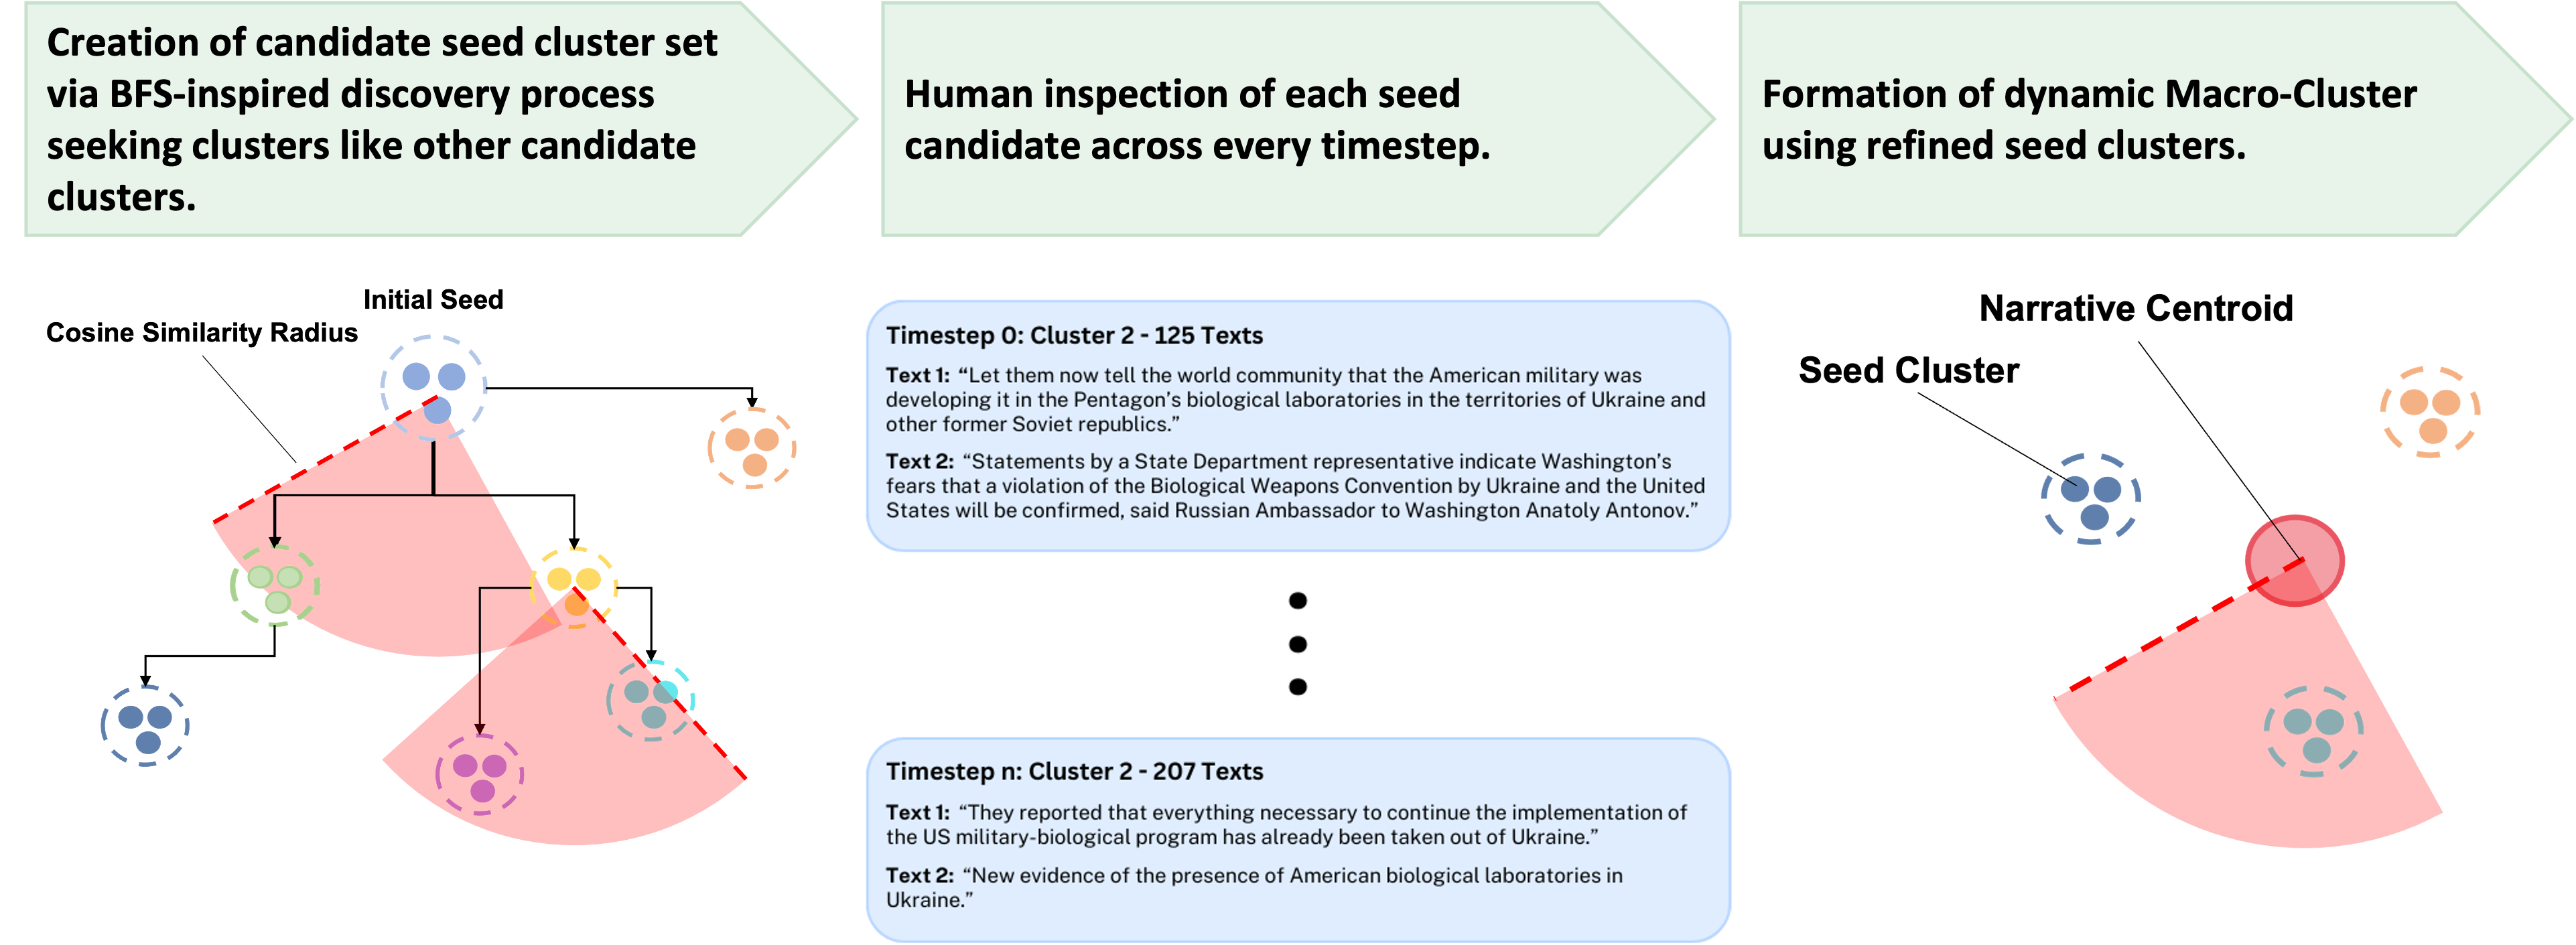![bfs.png](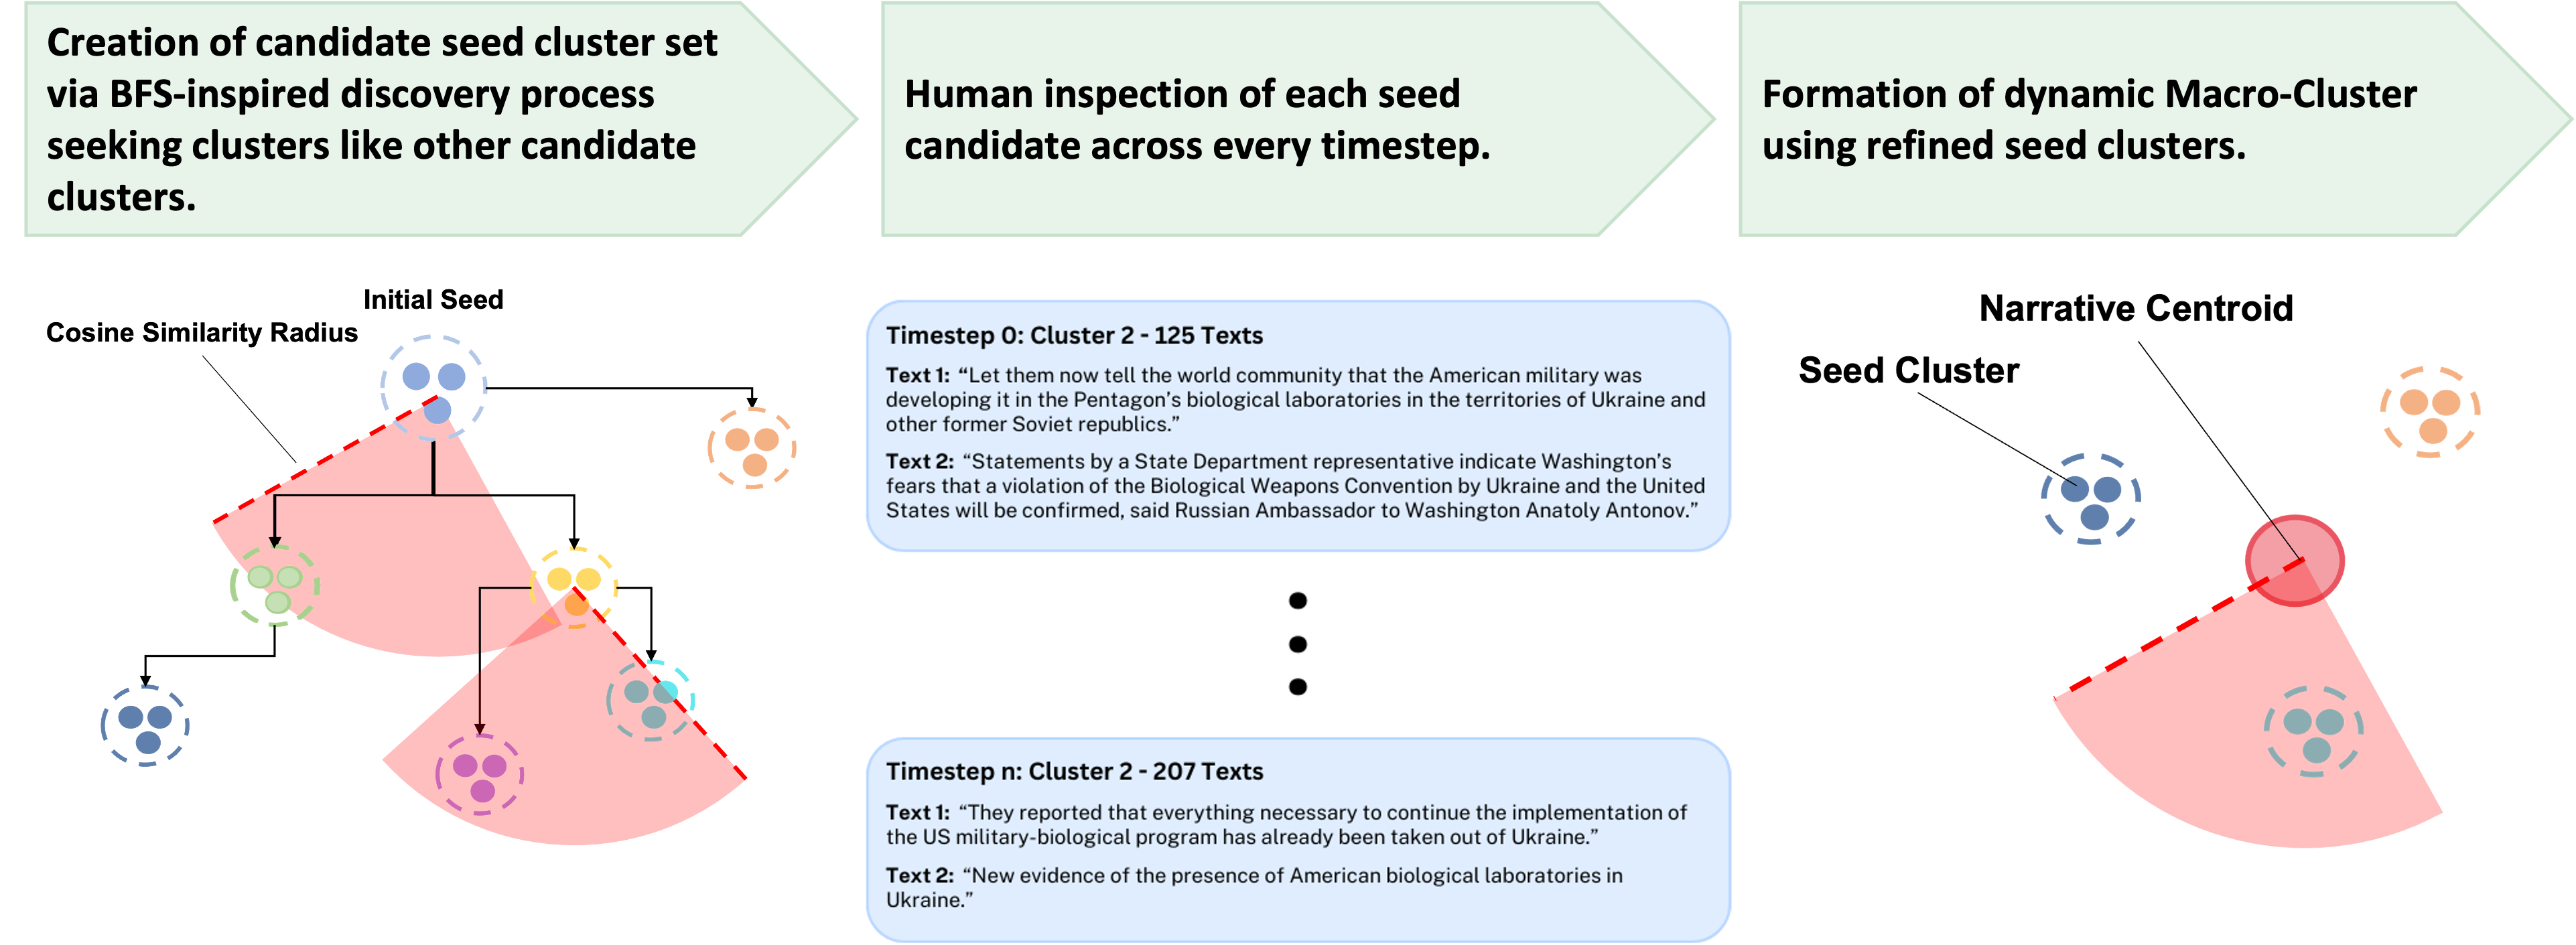![bfs.png](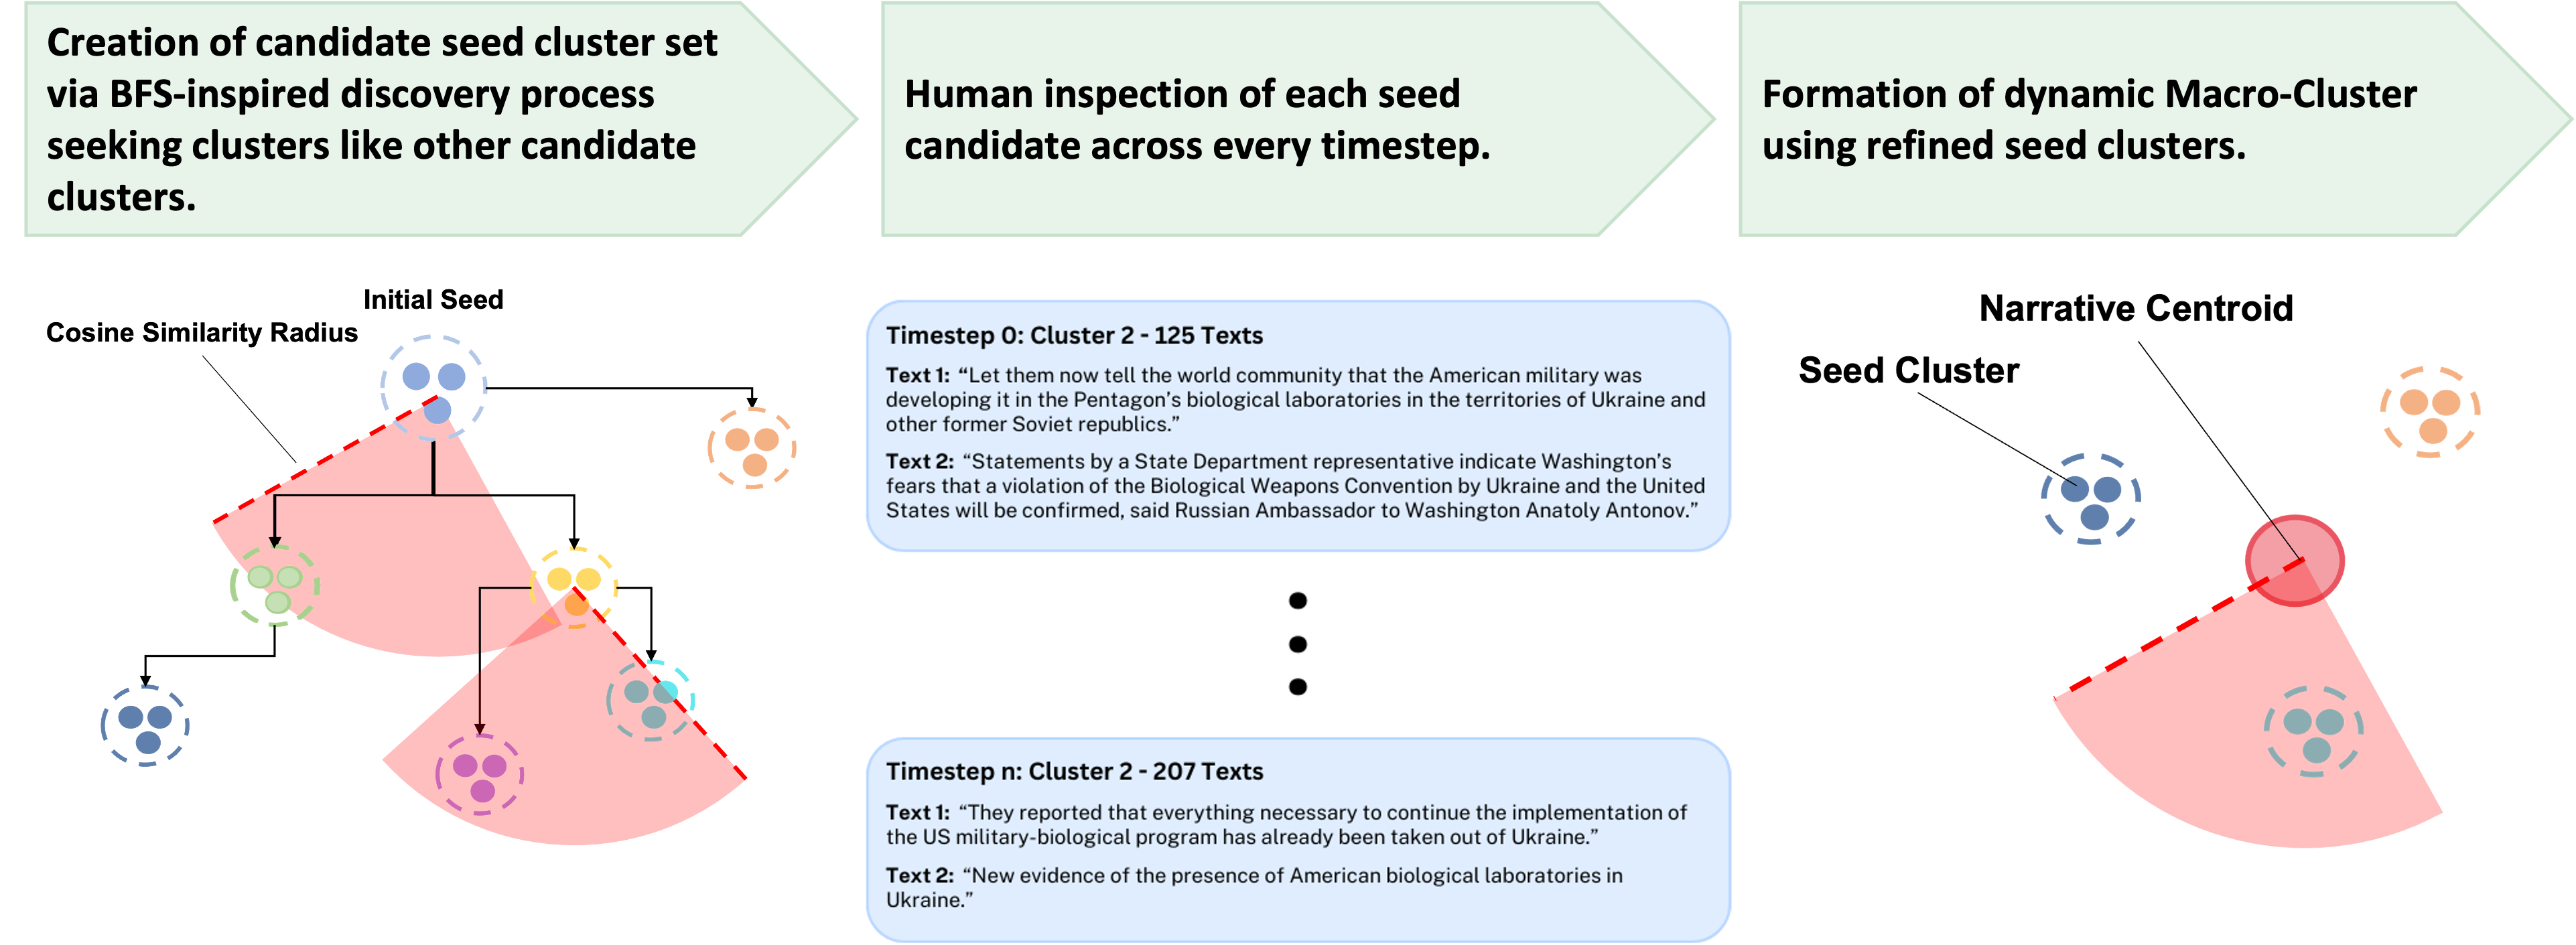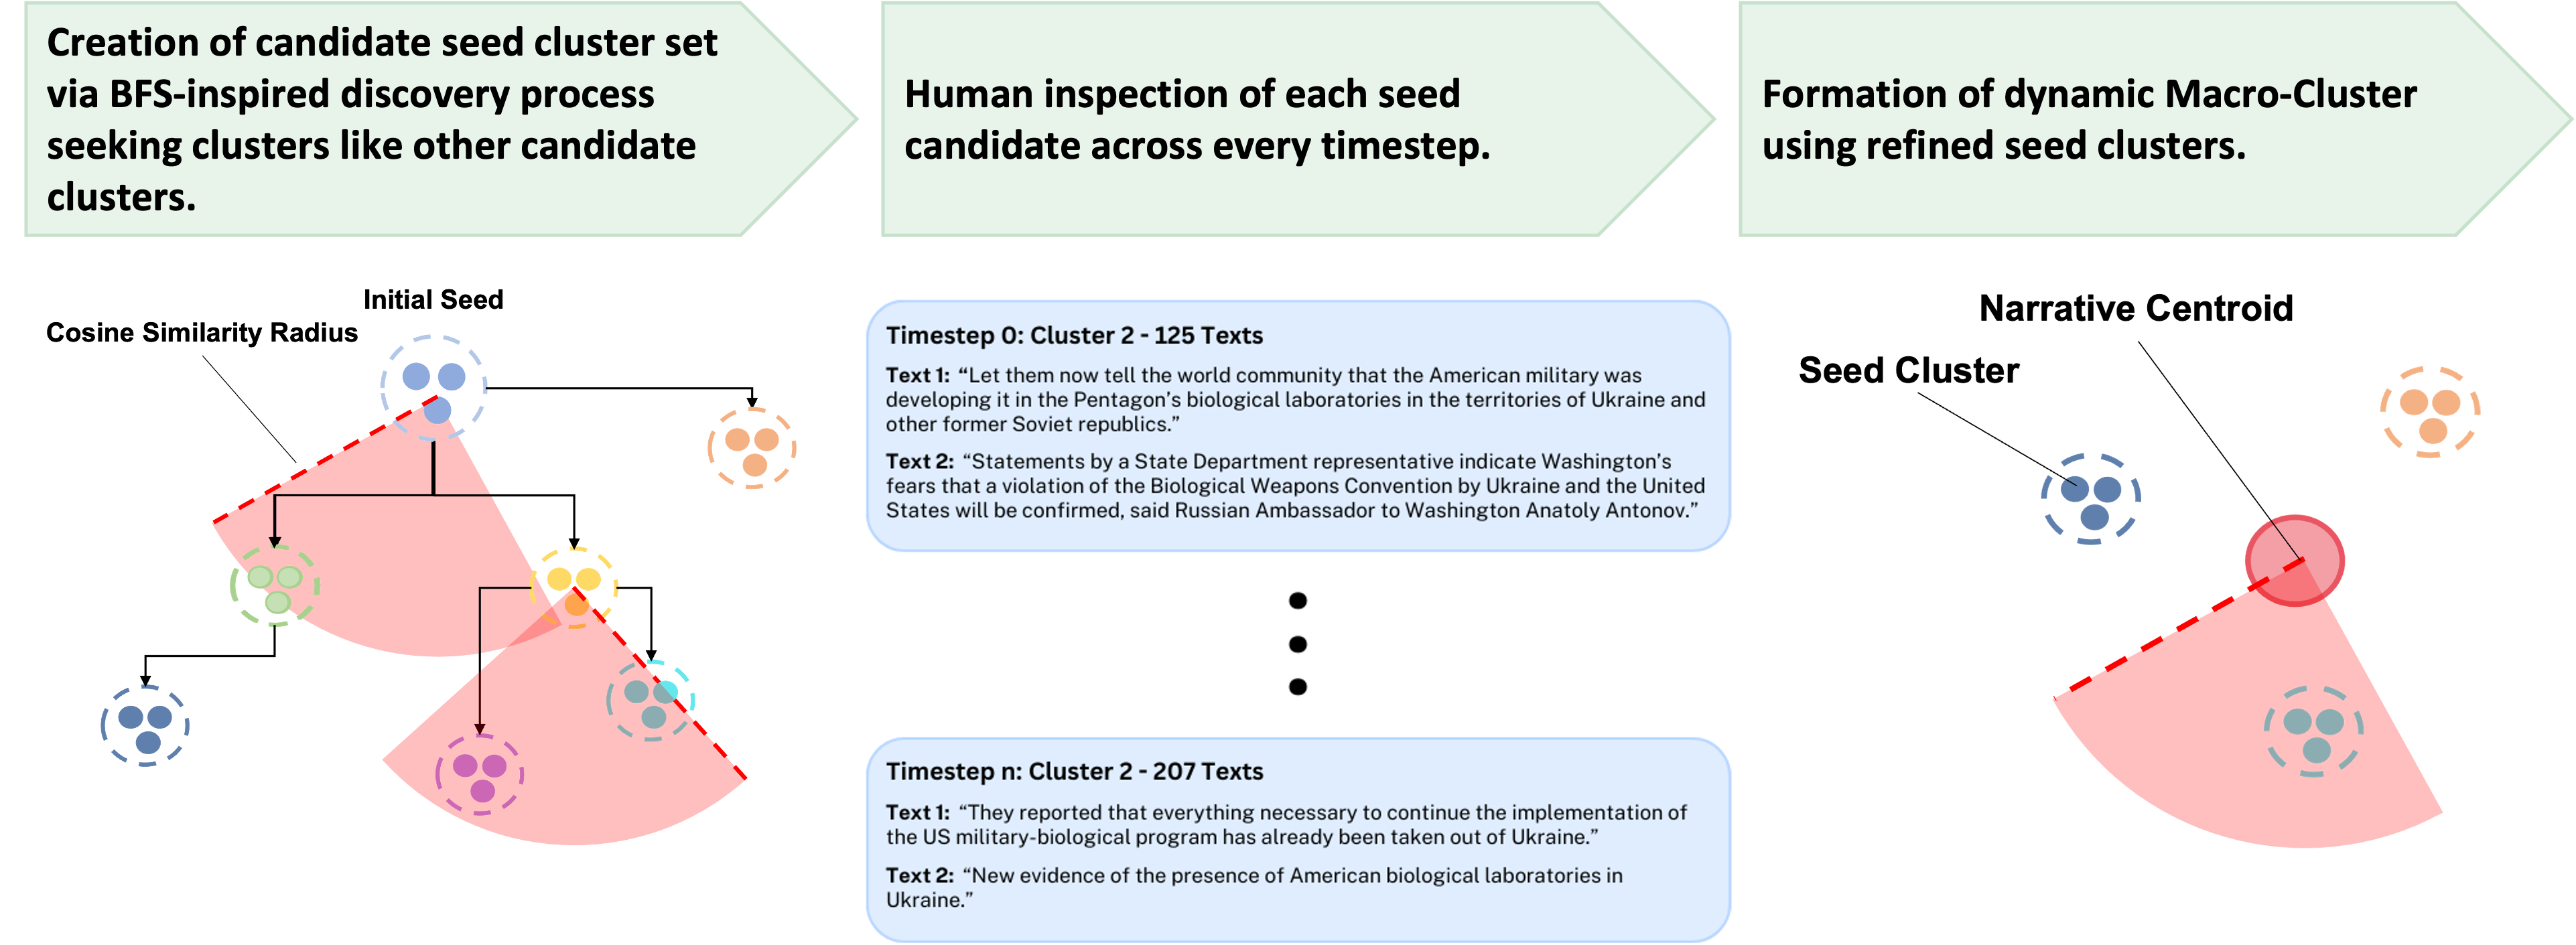)))# Data-Intensive Example

Here we present a data-intensive example, using telegram data (already cleaned and embedded) from the first 6 weeks of the Russo-Ukrainian war. Note that we do the first 6 weeks due to drive data size constraints.


Note that we provide separate access to the folder containing the data via [this link](https://drive.google.com/drive/folders/1NH7HSk3m5eR2wLcmPTTIIqJfC6w6Mkl9?usp=sharing). You will need to add this folder to your drive (and change data_dir_path) to then use this.

 **NOTE** - If you do not have premium colab, you should run this locally due to RAM constraints when using the embeddings. If on colab, you can simply go to the next section -- Cluster Trend Analysis, where we have already clustered for you





#### Utilities

In [ ]:
def get_rows_from_date_range(df, date_column, start_date, weeks):
    """
    Extracts rows from a DataFrame starting from a specified date for a number of weeks.

    Parameters:
    df (pd.DataFrame): The DataFrame to filter.
    date_column (str): The name of the column in the DataFrame that contains the date information.
    start_date (str or datetime): The start date from which to begin filtering.
    weeks (int): The number of weeks to include in the filter.

    Returns:
    pd.DataFrame: A DataFrame containing rows from the specified date range.
    """
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])

    # Calculate the end date by adding the specified number of weeks to the start date
    end_date = pd.to_datetime(start_date) + pd.to_timedelta(weeks * 7, unit='d')

    # Filter rows where the date is within the specified range
    return df[(df[date_column] >= pd.to_datetime(start_date)) & (df[date_column] < end_date)]



def filter_clusters_and_stats(df, cluster_column, min_cluster_size):
    """
    Removes clusters with fewer than min_cluster_size points and prints statistics,
    including the number of clusters.

    Parameters:
    df (pd.DataFrame): The DataFrame to filter.
    cluster_column (str): The name of the column in the DataFrame that contains the cluster information.
    min_cluster_size (int): The minimum number of points required for a cluster to be retained.

    Returns:
    pd.DataFrame: A DataFrame with smaller clusters removed.
    """
    # Original number of clusters
    original_cluster_count = df[cluster_column].nunique()

    # Filter out small clusters
    cluster_sizes = df[cluster_column].value_counts()
    large_clusters = cluster_sizes[cluster_sizes >= min_cluster_size].index
    filtered_df = df[df[cluster_column].isin(large_clusters)]

    # New number of clusters after filtering
    new_cluster_count = filtered_df[cluster_column].nunique()

    # Print number of clusters before and after filtering
    print("Original Number of Clusters:", original_cluster_count)
    print("New Number of Clusters:", new_cluster_count)

    # Calculate and print statistics for cluster sizes
    stats = ['min', '25%', '50%', '75%', 'max']
    original_stats = cluster_sizes.describe(percentiles=[.25, .5, .75])[stats]
    new_stats = filtered_df[cluster_column].value_counts().describe(percentiles=[.25, .5, .75])[stats]

    print("Original Stats:\n", original_stats)
    print("New Stats:\n", new_stats)

    # Calculate and print percentage change
    percent_change = ((new_stats - original_stats) / original_stats) * 100
    print("Percentage Change:\n", percent_change)

    # Return the filtered DataFrame
    return filtered_df



def top_dominant_clusters(df, date_column, start_date, weeks, cluster_column, n):
    """
    Shows the top n most dominant clusters for a given time period.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    date_column (str): The name of the column in the DataFrame that contains the date information.
    start_date (str or datetime): The start date from which to begin the period.
    weeks (int): The number of weeks to include in the period.
    cluster_column (str): The name of the column in the DataFrame that contains the cluster information.
    n (int): The number of top clusters to return.

    Returns:
    pd.Series: A Series containing the top n clusters and their counts.
    """
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])

    # Calculate the end date by adding the specified number of weeks to the start date
    end_date = pd.to_datetime(start_date) + pd.to_timedelta(weeks * 7, unit='d')

    # Filter rows where the date is within the specified range
    filtered_df = df[(df[date_column] >= pd.to_datetime(start_date)) & (df[date_column] < end_date)]

    # Count occurrences of each cluster within the date range
    cluster_counts = filtered_df[cluster_column].value_counts()

    # Return the top n clusters
    return cluster_counts.head(n)




def print_closest_points(df, cluster_column, centroid_column, embeddings_column, sentences_column, n):
    """
    Prints the closest n points to the centroid of each cluster based on cosine similarity.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    cluster_column (str): The name of the column containing the cluster labels.
    centroid_column (str): The name of the column containing the centroid information.
    embeddings_column (str): The name of the column containing the embeddings.
    sentences_column (str): The name of the column containing the sentences to print.
    n (int): The number of closest points to print for each cluster.
    """
    unique_clusters = df[cluster_column].unique()

    for cluster in unique_clusters:
        # Filter the DataFrame for the current cluster
        cluster_df = df[df[cluster_column] == cluster]

        # Calculate cosine similarity between each point's embedding and the centroid
        centroid = np.mean([np.array(x) for x in cluster_df[embeddings_column]], axis=0)
        similarities = cosine_similarity([centroid], np.stack(cluster_df[embeddings_column].values))[0]

        # Identify the top n closest points
        closest_indices = np.argsort(similarities)[::-1][:n]
        closest_points = cluster_df.iloc[closest_indices]

        # Print the information
        print(f"Cluster {cluster}:")
        for index, row in closest_points.iterrows():
            try:
                cosine_distance = 1 - similarities[index]
            except:
                cosine_distance = -1
            translation = GoogleTranslator(source='auto', target='en').translate(row[sentences_column])

            print(f"  Cosine Distance: {cosine_distance:.4f}, Sentence: '{translation}'")


def print_closest_rows_to_cluster(df, date_column, cluster_number, centroid_column, embeddings_column, cleaned_points_column, start_date, num_weeks, n):
    # Convert the date column to datetime
    df[date_column] = pd.to_datetime(df[date_column])

    # Calculate end date based on start date and number of weeks
    end_date = pd.to_datetime(start_date) + timedelta(weeks=num_weeks)

    # Filter the DataFrame for the desired date range and cluster
    mask = (df[date_column] >= start_date) & (df[date_column] < end_date) & (df['Cluster'] == cluster_number)
    filtered_df = df.loc[mask]

    # Get the centroid of the specified cluster
    centroid = df.loc[df['Cluster'] == cluster_number, centroid_column].iloc[0]

    # Calculate cosine distances and sort
    filtered_df['cosine_distance'] = filtered_df[embeddings_column].apply(lambda x: cosine(x, centroid))
    # filtered_df['cosine_distance'] = filtered_df[embeddings_column].apply(lambda x: cosine(x, centroid))
    filtered_df['cosine_distance'] = pd.to_numeric(filtered_df['cosine_distance'], errors='coerce')
    closest_rows = filtered_df.nsmallest(n, 'cosine_distance')

    # Print the n closest rows
    for index, row in closest_rows.iterrows():
        translation = GoogleTranslator(source='auto', target='en').translate(row[cleaned_points_column])
        print(f"\n- Cosine Distance = {row['cosine_distance']:.4f}, '{translation}'")





### Clustering

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Starting date and number of weeks
start_date_str = "2022-02-27"
num_weeks = 5

filter_type = 'pro-Russian' # pro-Russian or pro-Ukrainian
data_dir_path = '/content/drive/MyDrive/icwsm paper/Data'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Fill these global vars according to the DF column structure

In [ ]:
# Convert the start date to a datetime object
start_date = datetime.strptime(start_date_str, "%Y-%m-%d")

# Initialize an empty DataFrame to hold the combined data
combined_df = pd.DataFrame()
online_agglo = None
# Process each week
for week in range(num_weeks):
    # Calculate the date range for the current week
    start_week = start_date + timedelta(weeks=week)
    end_week = start_week + timedelta(weeks=1, days=-1)

    # Format dates for filenames
    start_week_str = start_week.strftime("%Y-%m-%d")
    end_week_str = end_week.strftime("%Y-%m-%d")

    # Define file paths
    tsv_file_path = f'{data_dir_path}/tsv_files/weekly_data_{start_week_str}_to_{end_week_str}.tsv'
    npy_file_path = f'{data_dir_path}/embeddings/weekly_data_{start_week_str}_to_{end_week_str}_embeddings.npy'
    # Load the TSV File
    df = pd.read_csv(tsv_file_path, sep='\t')

    # Load the NPY File
    embeddings = np.load(npy_file_path)

    # Align and add embeddings to the DataFrame
    if len(embeddings) == len(df):
        df['Embeddings'] = embeddings.tolist()
    else:
        print(f"The number of embeddings does not match the number of rows in the TSV file for the week starting {start_week_str}.")
        continue  # Skip to the next iteration if the data doesn't align

    # Filter by channel and date range
    filtered_df = filter_by_channel_and_date(df, 'pro-Russian', start_week_str, end_week_str)

    # Remove duplicates and filter short sentences
    filtered_df = df.drop_duplicates(subset=['cleaned_sentences', 'user'], keep='first')
    filtered_df = filtered_df[filtered_df['cleaned_sentences'].str.split().str.len() > 4]

    print(f"Week {week + 1}: {filtered_df.shape[0]} rows after cleaning and filtering")



        # Append to the combined DataFrame
    combined_df = pd.concat([combined_df, filtered_df], ignore_index=True)

Following the logic of these works, we remove clusters with less than or equal to a set value of points, regarding them as likely noise. Here, we set that value to 4

In [ ]:
noise_value = 4

In [ ]:
filtered_df = filter_clusters_and_stats(combined_df, 'Cluster', noise_value)

### Cluster Trend Analysis

#### Utilities

In [ ]:
import numpy as np
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, BoxSelectTool
from sklearn.manifold import TSNE
from bokeh.models import ColumnDataSource
import umap.umap_ as umap
from tqdm.auto import tqdm
from datetime import timedelta

# !pip uninstall bokeh==3.3.0 --force
# !pip install -U bokeh==3.2.0
def visualize_clusters_with_bokeh(df_in, start_date, end_date, freq, cluster_column, centroid_column, method='tsne'):
    df = df_in.copy()
    try:
        df[GLOBAL_DATE_FIELD] = pd.to_datetime(df[GLOBAL_DATE_FIELD])
        df.set_index(GLOBAL_DATE_FIELD, inplace=True)
    except:
        pass
    output_notebook()  # Render plot in Jupyter Notebook
    timesteps = pd.date_range(start=start_date, end=end_date, freq=freq)

    for i, current_time in enumerate(tqdm(timesteps[:-1], desc="Processing timesteps")):
        mask = (df.index >= current_time) & (df.index < timesteps[i+1])
        timestep_df = df.loc[mask]

        if not timestep_df.empty:
            grouped = timestep_df.groupby(cluster_column).agg({
                centroid_column: lambda x: np.mean(np.stack(x), axis=0),
                cluster_column: 'size'
            }).rename(columns={cluster_column: 'counts'})

            centroids = np.stack(grouped[centroid_column].values)
            cluster_ids = grouped.index.to_list()

            if method == 'tsne':
                reducer = TSNE(n_components=2, random_state=42)
            elif method == 'umap':
                reducer = umap.UMAP(n_components=2, random_state=42)
            embedding = reducer.fit_transform(centroids)
            source = ColumnDataSource(data={
                'x': embedding[:, 0],
                'y': embedding[:, 1],
                'cluster': cluster_ids,
                'size': [count * 0.3  for count in grouped['counts']]  # Adjust size for visibility
            })

            tooltips=[("Cluster", "@cluster"), ("Count", "@size")]
            p = figure(title=f'{method.upper()} Visualization - {current_time.strftime("%Y-%m-%d")}',
                       tools="pan,wheel_zoom,box_zoom,reset,lasso_select", tooltips=tooltips)


            hover = HoverTool(tooltips=[("Cluster", "@cluster"), ("Count", "@size")])
            p.add_tools(hover)
            p.circle(x='x', y='y', size='size', source=source, alpha=0.6,
                    hover_alpha=0.8, hover_color="red",
                    legend_label="Clusters")


            show(p)  # Show the plot



def filter_clusters_and_stats(df, min_cluster_size):
    """
    Removes clusters with fewer than min_cluster_size points and prints statistics,
    including the number of clusters.

    Parameters:
    df (pd.DataFrame): The DataFrame to filter.
    GLOBAL_CLUSTER_FIELD (str): The name of the column in the DataFrame that contains the cluster information.
    min_cluster_size (int): The minimum number of points required for a cluster to be retained.

    Returns:
    pd.DataFrame: A DataFrame with smaller clusters removed.
    """
    # Original number of clusters
    original_cluster_count = df[GLOBAL_CLUSTER_FIELD].nunique()

    # Filter out small clusters
    cluster_sizes = df[GLOBAL_CLUSTER_FIELD].value_counts()
    large_clusters = cluster_sizes[cluster_sizes >= min_cluster_size].index
    filtered_df = df[df[GLOBAL_CLUSTER_FIELD].isin(large_clusters)]

    # New number of clusters after filtering
    new_cluster_count = filtered_df[GLOBAL_CLUSTER_FIELD].nunique()

    # Print number of clusters before and after filtering
    print("Original Number of Clusters:", original_cluster_count)
    print("New Number of Clusters:", new_cluster_count)

    # Calculate and print statistics for cluster sizes
    stats = ['min', '25%', '50%', '75%', 'max']
    original_stats = cluster_sizes.describe(percentiles=[.25, .5, .75])[stats]
    new_stats = filtered_df[GLOBAL_CLUSTER_FIELD].value_counts().describe(percentiles=[.25, .5, .75])[stats]

    print("Original Stats:\n", original_stats)
    print("New Stats:\n", new_stats)

    # Calculate and print percentage change
    percent_change = ((new_stats - original_stats) / original_stats) * 100
    print("Percentage Change:\n", percent_change)

    # Return the filtered DataFrame
    return filtered_df


def get_rows_from_date_range(df, start_date, end_date):
    """
    Extracts rows from a DataFrame starting from a specified date for a number of weeks.

    Parameters:
    df (pd.DataFrame): The DataFrame to filter.
    GLOBAL_DATE_FIELD (str): The name of the column in the DataFrame that contains the date information.
    start_date (str or datetime): The start date from which to begin filtering.
    weeks (int): The number of weeks to include in the filter.

    Returns:
    pd.DataFrame: A DataFrame containing rows from the specified date range.
    """
    # Ensure the date column is in datetime format
    df[GLOBAL_DATE_FIELD] = pd.to_datetime(df[GLOBAL_DATE_FIELD])

    # Calculate the end date by adding the specified number of weeks to the start date

    # Filter rows where the date is within the specified range
    return df[(df[GLOBAL_DATE_FIELD] >= pd.to_datetime(start_date)) & (df[GLOBAL_DATE_FIELD] < end_date)]


def print_closest_rows_to_cluster(df, cluster_number, start_date, end_date, n=3, m=2):
    try:
        # Convert the date column to datetime
        df[GLOBAL_DATE_FIELD] = pd.to_datetime(df[GLOBAL_DATE_FIELD])
        start_date = pd.to_datetime(start_date).replace(hour=0, minute=0, second=0, microsecond=0)
        end_date = pd.to_datetime(end_date).replace(hour=23, minute=59, second=59, microsecond=999999)


        mask = (df[GLOBAL_DATE_FIELD] >= start_date) & (df[GLOBAL_DATE_FIELD] < end_date) & (df[GLOBAL_CLUSTER_FIELD] == cluster_number)
        # filtered_df = df.loc[mask]
        filtered_df = df.loc[mask]
        # print(filtered_df)



        # Get the centroid of the specified cluster
        centroid = filtered_df.loc[filtered_df[GLOBAL_CLUSTER_FIELD] == cluster_number].iloc[0]
        if GLOBAL_CENTROID_PRESENT:
            centroid_embedding = filtered_df[filtered_df[GLOBAL_CLUSTER_FIELD] == cluster_number][GLOBAL_EMBEDDINGS_COLUMN].iloc[0]
            # print(centroid[GLOBAL_EMBEDDINGS_COLUMN].shape[0])
            # print(centroid[GLOBAL_EMBEDDINGS_COLUMN].shape)

            # filtered_df['cosine_distance'] = filtered_df.apply(lambda row: cosine(row[GLOBAL_EMBEDDINGS_COLUMN], centroid), axis=1)
            # filtered_df['cosine_distance'] = filtered_df.apply(lambda row: cosine(row[GLOBAL_EMBEDDINGS_COLUMN], centroid_embedding), axis=1)

            filtered_df.loc[:, 'cosine_distance'] = filtered_df.apply(lambda row: cosine(row[GLOBAL_EMBEDDINGS_COLUMN], centroid_embedding), axis=1)


            # Calculate cosine distances and sort
            # filtered_df['cosine_distance'] = filtered_df[GLOBAL_EMBEDDINGS_COLUMN].apply(lambda x: cosine(x[GLOBAL_EMBEDDINGS_COLUMN], centroid))
            # filtered_df['cosine_distance'] = pd.to_numeric(filtered_df['cosine_distance'], errors='coerce')
            closest_rows = filtered_df.nsmallest(n, 'cosine_distance')

            # Print the n closest rows
            for index, row in closest_rows.iterrows():
                try:
                    cosine_distance = row['cosine_distance']
                except:
                    cosine_distance = None
                # translation = GoogleTranslator(source='auto', target='en').translate(row[cleaned_points_column])
                text = row[GLOBAL_TEXT_COLUMN]
                if GLOBAL_TRANSLATION_NECESSARY:
                    translation = GoogleTranslator(source='auto', target='en').translate(text)
                    print(f"\n\t- {row[GLOBAL_DATE_FIELD]}: Cosine Distance = {cosine_distance}, '{translation}'")
                else:
                    print(f"\n\t- {row[GLOBAL_DATE_FIELD]}: Cosine Distance = {cosine_distance}, '{text}'")

        print(f"\n\tRandom {m} Rows from Cluster {cluster_number}:")
        try:
            random_rows = filtered_df.sample(min(m, len(filtered_df)))
            for index, row in random_rows.iterrows():
                try:
                    cosine_distance = row['cosine_distance']
                except:
                    cosine_distance = None
                text = row[GLOBAL_TEXT_COLUMN]
                if GLOBAL_TRANSLATION_NECESSARY:
                    translation = GoogleTranslator(source='auto', target='en').translate(text)
                    print(f"\n\t- {row[GLOBAL_DATE_FIELD]}: Cosine Distance = {cosine_distance}, '{translation}'")
                else:
                    print(f"\n\t- {row[GLOBAL_DATE_FIELD]}: Cosine Distance = {cosine_distance}, '{text}'")

        except:
            pass
    except Exception as e:
        print(e)
        # pass



from collections import Counter
from math import log

def calculate_npmi_scores(cluster_texts):
    """
    Simple NPMI calculation for illustrative purposes.
    Args:
    cluster_texts (list of str): List of texts from the cluster.
    Returns:
    dict: Words and their NPMI scores.
    """
    # Flatten list of tokenized texts into a single list of words
    words = [word for text in cluster_texts for word in text.split()]
    word_count = len(words)
    word_freqs = Counter(words)

    # Calculate word pair frequencies
    word_pair_freqs = Counter()
    for text in cluster_texts:
        unique_words = list(set(text.split()))
        for i in range(len(unique_words)):
            for j in range(i + 1, len(unique_words)):
                word_pair_freqs[(unique_words[i], unique_words[j])] += 1
                word_pair_freqs[(unique_words[j], unique_words[i])] += 1  # Consider both pair directions

    npmi_scores = {}
    for (word1, word2), pair_freq in word_pair_freqs.items():
        p_x = word_freqs[word1] / word_count
        p_y = word_freqs[word2] / word_count
        p_xy = pair_freq / word_count
        pmi = log(p_xy / (p_x * p_y))
        npmi = pmi / -log(p_xy)
        npmi_scores[(word1, word2)] = npmi

    # Flatten NPMI scores, keeping the max score for each word
    flat_npmi_scores = {}
    for (word1, word2), score in npmi_scores.items():
        if word1 not in flat_npmi_scores or flat_npmi_scores[word1] < score:
            flat_npmi_scores[word1] = score
        if word2 not in flat_npmi_scores or flat_npmi_scores[word2] < score:
            flat_npmi_scores[word2] = score

    return flat_npmi_scores

def print_top_npmi_words(df, cluster_number, start_date, end_date, n=3):
    """
    Prints the top n NPMI words for a cluster within a specific interval.
    Args:
    df (pd.DataFrame): DataFrame containing the data.
    cluster_number (int): The cluster number.
    start_date (str): Start date of the interval.
    end_date (str): End date of the interval.
    n (int): Number of top NPMI words to print.
    """
    try:
        # Filter the DataFrame for the specified interval and cluster
        mask = (df[GLOBAL_DATE_FIELD] >= start_date) & (df[GLOBAL_DATE_FIELD] <= end_date) & (df[GLOBAL_CLUSTER_FIELD] == cluster_number)
        filtered_df = df.loc[mask]

        cluster_texts = filtered_df[GLOBAL_TEXT_COLUMN].tolist()
        npmi_scores = calculate_npmi_scores(cluster_texts)

        # Get top n words by NPMI score
        top_npmi_words = sorted(npmi_scores, key=npmi_scores.get, reverse=True)[:n]

        print(f"\nTop {n} NPMI words for Cluster {cluster_number}:")
        for word in top_npmi_words:
            print(f"{word}: {npmi_scores[word]:.4f}")
    except Exception as e:
        print(f"Error calculating NPMI for cluster {cluster_number}: {e}")



def analyze_cluster_trends(df, n, start_date, num_timesteps, similarity_threshold=0.9, freq_given='3D'):
    # Convert the date column to datetime
    df[GLOBAL_DATE_FIELD] = pd.to_datetime(df[GLOBAL_DATE_FIELD])

    # Calculate end date based on start date and number of weeks
    end_date = pd.to_datetime(start_date) + pd.Timedelta(weeks=num_timesteps)
    # end_date = pd.to_datetime(start_date) + pd.Timedelta(days=num_timesteps)

    # Filter the DataFrame for the desired date range
    mask = (df[GLOBAL_DATE_FIELD] >= start_date) & (df[GLOBAL_DATE_FIELD] < end_date)
    filtered_df = df.loc[mask]

    # Resample the DataFrame to weekly intervals and count occurrences of each cluster
    weekly_counts = filtered_df.groupby([pd.Grouper(key=GLOBAL_DATE_FIELD, freq=f'{freq_given}'), GLOBAL_CLUSTER_FIELD]).size().unstack(fill_value=0)
    # weekly_counts = filtered_df.groupby([pd.Grouper(key=GLOBAL_DATE_FIELD, freq='3D'), GLOBAL_CLUSTER_FIELD]).size().unstack(fill_value=0)

    # # Resample the DataFrame to weekly intervals and count occurrences of each cluster

    # Iterate over each week
    start_date = pd.to_datetime(start_date).replace(hour=0, minute=0, second=0, microsecond=0)
    # end_date = start_date + pd.Timedelta(weeks=1)
    if 'D' in freq_given:
        end_date = start_date + pd.Timedelta(days=int(freq_given[0]))
    elif 'W' in freq_given:
        end_date = start_date + pd.Timedelta(weeks=int(freq_given[0]))


    end_date = pd.to_datetime(end_date).replace(hour=23, minute=59, second=59, microsecond=999999)

    for i in range(1, len(weekly_counts)):
        previous_week = weekly_counts.iloc[i-1]
        current_week = weekly_counts.iloc[i]

        biggest = current_week.nlargest(n)

        # Calculate growth and shrinkage
        growth = current_week - previous_week
        shrinkage = previous_week - current_week

        # Top N growing and shrinking clusters
        top_growing = growth.nlargest(n)
        top_shrinking = shrinkage.nlargest(n)

        # Print results for the week
        print(f"\n\n---------")
        print(f"Timestep {i}: {start_date} - {end_date}")


        print("Top Growing Clusters:")

        for cluster in top_growing.index:
            prev_count = previous_week[cluster]
            new_count = current_week[cluster]
            percent_change = ((new_count - prev_count) / prev_count) * 100 if prev_count != 0 else float('inf')
            print(f"  ----------------------------   ")
            # channel_col="channel_name", date_field="date", embeddings_field="embeddings"
            print(f"  Cluster {cluster}: Prev Count = {prev_count}, New Count = {new_count}, Change = {percent_change:.2f}%")
            print_closest_rows_to_cluster(df, cluster, start_date, end_date, n=3, m=5)

        if 'D' in freq_given:
            start_date = start_date + pd.Timedelta(weeks=int(freq_given[0]), days=1)
            end_date = start_date + pd.Timedelta(weeks=int(freq_given[0]))
        elif 'W' in freq_given:
            start_date = start_date + pd.Timedelta(days=int(freq_given[0]) + 1)
            end_date = start_date + pd.Timedelta(days=int(freq_given[0]))



        end_date = pd.to_datetime(end_date).replace(hour=23, minute=59, second=59, microsecond=999999)
        print("\n")

def analyze_clusters_biggest_themes(df_in, n, start_date, num_timesteps, similarity_threshold=0.9, freq_given='3D'):
    df = df_in.copy()
    # Convert the date column to datetime
    df[GLOBAL_DATE_FIELD] = pd.to_datetime(df[GLOBAL_DATE_FIELD])

    # Calculate end date based on start date and number of weeks
    end_date = pd.to_datetime(start_date) + pd.Timedelta(weeks=num_timesteps)
    # end_date = pd.to_datetime(start_date) + pd.Timedelta(days=num_timesteps)

    # Filter the DataFrame for the desired date range
    mask = (df[GLOBAL_DATE_FIELD] >= start_date) & (df[GLOBAL_DATE_FIELD] < end_date)
    filtered_df = df.loc[mask]

    # Resample the DataFrame to weekly intervals and count occurrences of each cluster
    weekly_counts = filtered_df.groupby([pd.Grouper(key=GLOBAL_DATE_FIELD, freq=f'{freq_given}'), GLOBAL_CLUSTER_FIELD]).size().unstack(fill_value=0)
    # weekly_counts = filtered_df.groupby([pd.Grouper(key=GLOBAL_DATE_FIELD, freq='3D'), GLOBAL_CLUSTER_FIELD]).size().unstack(fill_value=0)

    # Iterate over each week
    start_date = pd.to_datetime(start_date).replace(hour=0, minute=0, second=0, microsecond=0)
    if 'D' in freq_given:
        end_date = start_date + pd.Timedelta(days=int(freq_given[0]))
    elif 'W' in freq_given:
        end_date = start_date + pd.Timedelta(weeks=int(freq_given[0]))
    end_date = pd.to_datetime(end_date).replace(hour=23, minute=59, second=59, microsecond=999999)

    for i in range(1, len(weekly_counts)):
        previous_week = weekly_counts.iloc[i-1]
        current_week = weekly_counts.iloc[i]

        biggest = current_week.nlargest(n)

        # Calculate growth and shrinkage
        growth = current_week - previous_week
        shrinkage = previous_week - current_week

        # Top N growing and shrinking clusters
        top_growing = biggest.nlargest(n)
        top_shrinking = shrinkage.nlargest(n)

        # Print results for the week
        print(f"\n\n---------")
        print(f"Timestep {i}: {start_date} - {end_date}")


        print("Biggest Clusters:")

        for cluster in top_growing.index:
            prev_count = previous_week[cluster]
            new_count = current_week[cluster]
            percent_change = ((new_count - prev_count) / prev_count) * 100 if prev_count != 0 else float('inf')
            print(f"  ----------------------------   ")
            # channel_col="channel_name", date_field="date", embeddings_field="embeddings"
            print(f"  Cluster {cluster}: Prev Count = {prev_count}, New Count = {new_count}, Change = {percent_change:.2f}%")
            try:
                print_closest_rows_to_cluster(df, cluster, start_date, end_date, n=3, m=5)
            except Exception as e:
                print(e)

        if 'D' in freq_given:
            start_date = start_date + pd.Timedelta(weeks=int(freq_given[0]), days=1)
            end_date = start_date + pd.Timedelta(weeks=int(freq_given[0]))
        elif 'W' in freq_given:
            start_date = start_date + pd.Timedelta(days=int(freq_given[0]) + 1)
            end_date = start_date + pd.Timedelta(days=int(freq_given[0]))

        end_date = pd.to_datetime(end_date).replace(hour=23, minute=59, second=59, microsecond=999999)
        print("\n")


def find_and_print_closest_clusters(df_in, cluster_number, similarity_threshold=None):
    df = df_in.copy()
    # Extract the centroid for the specified cluster
    target_centroid = df.loc[df[GLOBAL_CLUSTER_FIELD] == cluster_number, GLOBAL_CENTROID_COLUMN].iloc[0]

    # Calculate cosine similarity with other clusters
    similarities = {}
    for other_cluster in df[GLOBAL_CLUSTER_FIELD].unique():
        if other_cluster != cluster_number:
            other_centroid = df.loc[df[GLOBAL_CLUSTER_FIELD] == other_cluster, GLOBAL_CENTROID_COLUMN].iloc[0]
            similarity = 1 - cosine(target_centroid, other_centroid)
            similarities[other_cluster] = similarity

    # Convert to a DataFrame for easier manipulation
    similarity_df = pd.DataFrame(list(similarities.items()), columns=[GLOBAL_CLUSTER_FIELD, 'Similarity'])

    # Apply similarity threshold if provided
    if similarity_threshold is not None:
        similarity_df = similarity_df[similarity_df['Similarity'] >= similarity_threshold]

    # Sort by similarity
    similarity_df.sort_values(by='Similarity', ascending=False, inplace=True)

    clusters = []
    # Print each cluster number and its similarity
    for index, row in similarity_df.iterrows():
        clusters.append(int(row[GLOBAL_CLUSTER_FIELD]))
        print(f"Cluster {row[GLOBAL_CLUSTER_FIELD]}: Similarity = {row['Similarity']:.4f}")
    return clusters

def bfs_explore_clusters(df_in, similarity_threshold, starting_seeds, max_iterations=1000):
    df = df_in.copy()
    visited_clusters = set(starting_seeds)
    queue = deque(starting_seeds)
    all_similar_clusters = set(starting_seeds)

    iterations = 0
    while queue and iterations < max_iterations:
        print(f'iterations: {iterations}')
        print(f'Length of similar clusters: {len(all_similar_clusters)}')
        current_cluster = queue.popleft()

        similar_clusters = find_and_print_closest_clusters(df, current_cluster, similarity_threshold)

        for cluster in similar_clusters:
            if cluster not in visited_clusters:
                visited_clusters.add(cluster)
                queue.append(cluster)
                all_similar_clusters.add(cluster)

        iterations += 1

    return list(all_similar_clusters)

def get_starting_seeds(df_in, starting_seed, similarity_threshold, starting_week, num_timesteps, freq_given='1W'):
    df = df_in.copy()
    index = 0
    starting_seeds_set = set()
    starting_seeds_set.add(starting_seed)
    start_date = starting_week

    start_date = pd.to_datetime(start_date).replace(hour=0, minute=0, second=0, microsecond=0)
    # end_date = start_date + pd.Timedelta(weeks=1)
    if 'D' in freq_given:
        end_date = start_date + pd.Timedelta(days=int(freq_given[0]))
    elif 'W' in freq_given:
        end_date = start_date + pd.Timedelta(weeks=int(freq_given[0]))


    # all_start
    for week_num in range(num_timesteps):
        start_date = pd.to_datetime(start_date).replace(hour=0, minute=0, second=0, microsecond=0)
        end_date = pd.to_datetime(end_date).replace(hour=23, minute=59, second=59, microsecond=999999)


        curr_filtered_week_df = get_rows_from_date_range(df, start_date, end_date)
        try:
            starting_seeds_curr_week = find_and_print_closest_clusters(curr_filtered_week_df, cluster_number=starting_seed, similarity_threshold=similarity_threshold)
            for seed in starting_seeds_curr_week:
                try:
                    print(f'\n--\nCluster {seed} - Timestep {week_num} - {start_date}:')
                    print_closest_rows_to_cluster(df, seed, start_date, end_date, n=3, m=2)
                    starting_seeds_set.add(seed)
                except Exception as e:
                    print(e)
        except:
            pass
        index += 1
        if 'D' in freq_given:
            start_date = start_date + pd.Timedelta(weeks=int(freq_given[0]), days=1)
            end_date = start_date + pd.Timedelta(weeks=int(freq_given[0]))
        elif 'W' in freq_given:
            start_date = start_date + pd.Timedelta(days=int(freq_given[0]) + 1)
            end_date = start_date + pd.Timedelta(days=int(freq_given[0]))
    print(f'Gathered {len(starting_seeds_set)} starting seeds: {list(starting_seeds_set)}')
    return list(starting_seeds_set)


def create_cluster_line_chart_percentage(weekly_data, total_weeks=10):
    # Prepare the data
    line_chart_data = pd.DataFrame(index=range(1, total_weeks + 1))

    # Calculate weekly totals
    weekly_totals = [sum(cluster['point_count'] for cluster in week.values()) for week in weekly_data]

    for week, clusters in enumerate(weekly_data, 1):
        for cluster_id, cluster_info in clusters.items():
            # Calculate the percentage of total points for the cluster
            percentage_of_total = (cluster_info['point_count'] / weekly_totals[week - 1]) * 100 if weekly_totals[week - 1] > 0 else 0
            line_chart_data.at[week, cluster_id] = percentage_of_total

    line_chart_data.fillna(0, inplace=True)

    # Plot the line chart
    plt.figure(figsize=(15, 10))
    for cluster_id in line_chart_data.columns:
        plt.plot(line_chart_data.index, line_chart_data[cluster_id], marker='o', label=f'Cluster {cluster_id}')

    plt.title('Cluster Activity Over Time (Percentage of Total)')
    plt.xlabel('Week Number')
    plt.ylabel('Percentage of Total Points')
    plt.legend()
    plt.show()


import pandas as pd
import matplotlib.pyplot as plt

def analyze_and_plot_cluster_activity_messages(df, min_rows, timestep_size):
    """
    Analyze the emergence and popularity of clusters and the sheer number of messages over time in a DataFrame,
    and plot the results with a bar chart for active clusters and a line chart for message count.

    Parameters:
    - df: DataFrame containing the data.
    - GLOBAL_CLUSTER_FIELD: The name of the column with datetime information.
    - cluster_col: The name of the column with cluster identifiers.
    - min_rows: Minimum number of rows for a cluster to be considered active.
    - timestep_size: The size of the timestep to analyze, using pandas offset aliases.
    """
    # Make a copy of the DataFrame to avoid manipulating the original
    df_copy = df.copy()

    # Convert the date column to datetime format
    df_copy[GLOBAL_DATE_FIELD] = pd.to_datetime(df_copy[GLOBAL_DATE_FIELD])

    # Group by timestep and cluster, count the rows, and filter for active clusters
    grouped = df_copy.set_index(GLOBAL_DATE_FIELD).groupby([pd.Grouper(freq=timestep_size), GLOBAL_CLUSTER_FIELD]).size().reset_index(name='Count')
    active_clusters = grouped[grouped['Count'] >= min_rows]

    # Count the number of active clusters per timestep
    active_clusters_by_time = active_clusters.groupby(GLOBAL_DATE_FIELD)[GLOBAL_CLUSTER_FIELD].nunique()

    # Calculate total message count per timestep
    total_messages_by_time = df_copy.set_index(GLOBAL_DATE_FIELD).groupby(pd.Grouper(freq=timestep_size)).size()

    # Plotting
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar chart for the number of active clusters
    ax1.bar(active_clusters_by_time.index, active_clusters_by_time.values, color='skyblue', label='Active Clusters')
    ax1.set_xlabel('TimeStep')
    ax1.set_ylabel('Number of Active Clusters', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    ax1.set_title('Active Clusters and Total Messages Over Time')

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()
    ax2.plot(total_messages_by_time.index, total_messages_by_time.values, color='darkorange', label='Total Messages', marker='o', linestyle='-', linewidth=1.5)
    ax2.set_ylabel('Total Messages', color='darkorange')
    ax2.tick_params(axis='y', labelcolor='darkorange')

    # Combine legends of both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    fig.tight_layout()  # Adjust the layout to make room for the legend
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

import pandas as pd
from collections import Counter
from math import log

def calculate_npmi_scores(cluster_texts):
    """
    Simple NPMI calculation for illustrative purposes.
    Args:
    cluster_texts (list of str): List of texts from the cluster.
    Returns:
    dict: Words and their NPMI scores.
    """
    # Flatten list of tokenized texts into a single list of words
    words = [word for text in cluster_texts for word in text.split()]
    word_count = len(words)
    word_freqs = Counter(words)

    # Calculate word pair frequencies
    word_pair_freqs = Counter()
    for text in cluster_texts:
        unique_words = list(set(text.split()))
        for i in range(len(unique_words)):
            for j in range(i + 1, len(unique_words)):
                word_pair_freqs[(unique_words[i], unique_words[j])] += 1
                word_pair_freqs[(unique_words[j], unique_words[i])] += 1  # Consider both pair directions

    npmi_scores = {}
    for (word1, word2), pair_freq in word_pair_freqs.items():
        p_x = word_freqs[word1] / word_count
        p_y = word_freqs[word2] / word_count
        p_xy = pair_freq / word_count
        pmi = log(p_xy / (p_x * p_y))
        npmi = pmi / -log(p_xy)
        npmi_scores[(word1, word2)] = npmi

    # Flatten NPMI scores, keeping the max score for each word
    flat_npmi_scores = {}
    for (word1, word2), score in npmi_scores.items():
        if word1 not in flat_npmi_scores or flat_npmi_scores[word1] < score:
            flat_npmi_scores[word1] = score
        if word2 not in flat_npmi_scores or flat_npmi_scores[word2] < score:
            flat_npmi_scores[word2] = score

    return flat_npmi_scores

def print_top_npmi_words(df, cluster_number, start_date, end_date, n=3):
    """
    Prints the top n NPMI words for a cluster within a specific interval.
    Args:
    df (pd.DataFrame): DataFrame containing the data.
    cluster_number (int): The cluster number.
    start_date (str): Start date of the interval.
    end_date (str): End date of the interval.
    n (int): Number of top NPMI words to print.
    """
    try:
        # Filter the DataFrame for the specified interval and cluster
        mask = (df[GLOBAL_DATE_FIELD] >= start_date) & (df[GLOBAL_DATE_FIELD] <= end_date) & (df[GLOBAL_CLUSTER_FIELD] == cluster_number)
        filtered_df = df.loc[mask]

        cluster_texts = filtered_df[GLOBAL_TEXT_COLUMN].tolist()
        npmi_scores = calculate_npmi_scores(cluster_texts)

        # Get top n words by NPMI score
        top_npmi_words = sorted(npmi_scores, key=npmi_scores.get, reverse=True)[:n]

        print(f"\nTop {n} NPMI words for Cluster {cluster_number}:")
        for word in top_npmi_words:
            print(f"{word}")
    except Exception as e:
        print(f"Error calculating NPMI for cluster {cluster_number}: {e}")


def analyze_cluster_trends_new(df_in, n, start_date, num_timesteps, similarity_threshold=0.9, freq_given='3D'):
    # Ensure GLOBAL_DATE_FIELD is in datetime format
    df = df_in.copy()
    df[GLOBAL_DATE_FIELD] = pd.to_datetime(df[GLOBAL_DATE_FIELD])

    # Helper function to adjust the end date based on the frequency given
    def adjust_end_date(start, freq):
        if 'D' in freq:
            return start + pd.Timedelta(days=int(freq[:-1]))
        elif 'W' in freq:
            return start + pd.Timedelta(weeks=int(freq[:-1]))
        else:
            raise ValueError("Unsupported frequency. Use 'D' for days or 'W' for weeks.")

    current_start_date = pd.to_datetime(start_date)
    prev_interval_counts = None  # To store counts from the previous interval

    for timestep in range(num_timesteps):
        current_end_date = adjust_end_date(current_start_date, freq_given)

        # Filter DataFrame for the current interval
        mask = (df[GLOBAL_DATE_FIELD] >= current_start_date) & (df[GLOBAL_DATE_FIELD] < current_end_date)
        interval_df = df.loc[mask]

        # Get counts of each cluster in the current interval
        interval_counts = interval_df.groupby(GLOBAL_CLUSTER_FIELD).size()

        if prev_interval_counts is not None:
            # Calculate growth only if there's a previous interval to compare with
            growth = interval_counts.subtract(prev_interval_counts, fill_value=0)

            # Calculate percentage change
            percent_change = growth.divide(prev_interval_counts).multiply(100).replace([float('inf'), -float('inf')], np.nan).fillna(0)

            # Get top N clusters based on growth
            top_growing = growth.nlargest(n)

            print(f"\n\n---------")
            print(f"Timestep {timestep + 1}: {current_start_date} - {current_end_date}")
            print("Top Growing Clusters:")
            for cluster in top_growing.index:
                print(f"  Cluster {cluster}: Prev Count = {prev_interval_counts.get(cluster, 0)}, New Count = {interval_counts.get(cluster, 0)}, Growth = {growth[cluster]}, Change = {percent_change[cluster]:.2f}%")
                print_closest_rows_to_cluster(df, cluster, current_start_date, current_end_date, n=2, m=2)

        else:
             # Default to showing the largest clusters for the first timestep
            top_clusters = interval_counts.nlargest(n)
            print("Defaulting to biggest clusters (no previous timestep to calculate growth):")
            for cluster in top_clusters.index:
                print(f"  Cluster {cluster}: Count = {interval_counts[cluster]}")
                print_closest_rows_to_cluster(df, cluster, current_start_date, current_end_date, n=2, m=2)

        # Update for the next interval
        prev_interval_counts = interval_counts
        current_start_date = current_end_date



def analyze_persistent_clusters(df, persistent_clusters_df, start_date, num_timesteps, freq_given='3D', top_n=None):
    """
    Analyzes and prints details for the top N most persistent clusters over a series of timesteps,
    where persistent_clusters_df is a DataFrame with 'Cluster' and 'Persistence_Score' columns.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    persistent_clusters_df (pd.DataFrame): DataFrame containing the most persistent clusters and their scores.
    start_date (str): The start date for the analysis period.
    num_timesteps (int): The number of timesteps to consider.
    freq_given (str): The frequency for breaking down the analysis period into timesteps.
    top_n (int, optional): The number of top persistent clusters to consider. If None, all clusters are considered.
    """
    # Extract cluster numbers from the DataFrame and limit to top_n if specified
    if top_n is not None:
        persistent_clusters = persistent_clusters_df['Cluster'].head(top_n).tolist()
    else:
        persistent_clusters = persistent_clusters_df['Cluster'].tolist()    # Extract cluster numbers from the DataFrame

    # Ensure GLOBAL_DATE_FIELD is in datetime format
    df[GLOBAL_DATE_FIELD] = pd.to_datetime(df[GLOBAL_DATE_FIELD])

    # Helper function to adjust the end date based on the frequency given
    def adjust_end_date(start, freq):
        if 'D' in freq:
            return start + pd.Timedelta(days=int(freq[:-1]))
        elif 'W' in freq:
            return start + pd.Timedelta(weeks=int(freq[:-1]))
        else:
            raise ValueError("Unsupported frequency. Use 'D' for days or 'W' for weeks.")

    current_start_date = pd.to_datetime(start_date)

    for timestep in range(num_timesteps):
        current_end_date = adjust_end_date(current_start_date, freq_given)

        # Filter DataFrame for the current interval
        mask = (df[GLOBAL_DATE_FIELD] >= current_start_date) & (df[GLOBAL_DATE_FIELD] < current_end_date)
        interval_df = df.loc[mask]

        print(f"\nTimestep {timestep + 1}: {current_start_date.date()} - {current_end_date.date()}")

        for cluster in persistent_clusters:
            # Ensure the cluster is present in the current interval before proceeding
            if cluster in interval_df[GLOBAL_CLUSTER_FIELD].values:
                cluster_size = interval_df[interval_df[GLOBAL_CLUSTER_FIELD] == cluster].shape[0]
                print(f"Cluster {cluster}: Count = {cluster_size}")
                # Make sure to implement or adjust print_closest_rows_to_cluster accordingly
                print_closest_rows_to_cluster(df, cluster, current_start_date, current_end_date, n=2, m=2)

        # Update for the next interval
        current_start_date = current_end_date




def analyze_cluster_trends_new_largest_themes(df_in, n, start_date, num_timesteps, similarity_threshold=0.9, freq_given='3D'):
    # Ensure GLOBAL_DATE_FIELD is in datetime format
    df = df_in.copy()
    df[GLOBAL_DATE_FIELD] = pd.to_datetime(df[GLOBAL_DATE_FIELD])

    # Helper function to adjust the end date based on the frequency given
    def adjust_end_date(start, freq):
        if 'D' in freq:
            return start + pd.Timedelta(days=int(freq[:-1]))
        elif 'W' in freq:
            return start + pd.Timedelta(weeks=int(freq[:-1]))
        else:
            raise ValueError("Unsupported frequency. Use 'D' for days or 'W' for weeks.")

    current_start_date = pd.to_datetime(start_date)
    prev_interval_counts = None  # To store counts from the previous interval
            # Get counts of each cluster in the current interval

    for timestep in range(num_timesteps):
        current_end_date = adjust_end_date(current_start_date, freq_given)

        # Filter DataFrame for the current interval
        mask = (df[GLOBAL_DATE_FIELD] >= current_start_date) & (df[GLOBAL_DATE_FIELD] < current_end_date)
        interval_df = df.loc[mask]

        # Get counts of each cluster in the current interval
        interval_counts = interval_df.groupby(GLOBAL_CLUSTER_FIELD).size()


         # Default to showing the largest clusters for the first timestep
        top_clusters = interval_counts.nlargest(n)
        print("Defaulting to biggest clusters:")
        for cluster in top_clusters.index:
            print(f"  Cluster {cluster}: Count = {interval_counts[cluster]}")
            print_closest_rows_to_cluster(df, cluster, current_start_date, current_end_date, n=2, m=2)

        # Update for the next interval
        prev_interval_counts = interval_counts
        current_start_date = current_end_date

def calculate_cluster_similarity_over_time(df, cluster_number, start_date, end_date, similarity_threshold=0.9, freq_given='3D'):
    """
    Calculates the number of clusters within a given cosine distance of a specified cluster's centroid over timesteps.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    cluster_number (int): The cluster number to analyze.
    start_date (str): The start date for the analysis period.
    end_date (str): The end date for the analysis period.
    similarity_threshold (float): The threshold for cosine similarity to consider clusters as close.
    freq_given (str): The frequency for breaking down the analysis period into timesteps (e.g., '3D' for every 3 days).

    Returns:
    pd.DataFrame: A DataFrame with each row representing a timestep, and the number of clusters close to the specified cluster.
    """
    # Convert the date column to datetime if not already
    df[GLOBAL_DATE_FIELD] = pd.to_datetime(df[GLOBAL_DATE_FIELD])

    # Filter DataFrame for the analysis period
    mask = (df[GLOBAL_DATE_FIELD] >= start_date) & (df[GLOBAL_DATE_FIELD] <= end_date)
    period_df = df.loc[mask]

    # Break down the period into timesteps
    timesteps = pd.date_range(start=start_date, end=end_date, freq=freq_given)

    # Prepare a list to collect data for each timestep
    close_clusters_data = []

    for i in range(len(timesteps)-1):
        timestep_start = timesteps[i]
        timestep_end = timesteps[i+1]

        # Filter for the current timestep
        timestep_df = period_df[(period_df[GLOBAL_DATE_FIELD] >= timestep_start) & (period_df[GLOBAL_DATE_FIELD] < timestep_end)]

        # Find clusters close to the specified cluster's centroid for this timestep
        # Note: Adjust the function call if necessary to match your implementation
        close_clusters = find_and_print_closest_clusters(timestep_df, cluster_number, similarity_threshold)

        # Collect data for the current timestep
        close_clusters_data.append({
            'Timestep_Start': timestep_start,
            'Timestep_End': timestep_end,
            'Close_Clusters_Count': len(close_clusters)
        })

    # Convert the list of data into a DataFrame
    close_clusters_over_time = pd.DataFrame(close_clusters_data)

    return close_clusters_over_time


import pandas as pd

def find_persistent_clusters(df, start_date, end_date, freq_given='3D', n=5):
    """
    Identifies clusters that consistently appear in the top n positions over time,
    considering both the frequency of appearances and their average ranks.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    start_date (str): The start date for the analysis period.
    end_date (str): The end date for the analysis period.
    freq_given (str): The frequency for breaking down the analysis period into timesteps.
    n (int): The number of top clusters to consider in each interval.

    Returns:
    pd.DataFrame: A DataFrame of clusters and their adjusted persistence scores, sorted by most persistent.
    """
    # Ensure date column is in datetime format
    df[GLOBAL_DATE_FIELD] = pd.to_datetime(df[GLOBAL_DATE_FIELD])

    # Initialize the timesteps
    timesteps = pd.date_range(start=start_date, end=end_date, freq=freq_given)

    # Dictionary to track rankings and appearances
    rankings = {}

    current_start_date = pd.to_datetime(start_date)

    for i in range(len(timesteps)-1):
        current_end_date = timesteps[i+1]

        # Filter DataFrame for the current interval
        mask = (df[GLOBAL_DATE_FIELD] >= current_start_date) & (df[GLOBAL_DATE_FIELD] < current_end_date)
        interval_df = df.loc[mask]

        # Get counts of each cluster in the current interval and rank them
        interval_counts = interval_df.groupby(GLOBAL_CLUSTER_FIELD).size().nlargest(n)

        # Update rankings and appearances
        for rank, cluster in enumerate(interval_counts.index, start=1):
            if cluster not in rankings:
                rankings[cluster] = []
            rankings[cluster].append(rank)

        # Update for the next interval
        current_start_date = current_end_date

    # Calculate persistence scores as the inverse of the average rank (higher score indicates higher persistence)
    persistence_scores = {cluster: 1 / (sum(ranks) / len(ranks)) for cluster, ranks in rankings.items() if len(ranks) > 0}

    # Convert to DataFrame and sort by persistence scores
    persistence_df = pd.DataFrame(list(persistence_scores.items()), columns=[GLOBAL_CLUSTER_FIELD, 'Persistence_Score']).sort_values(by='Persistence_Score', ascending=False)

    return persistence_df


import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def visualize_cluster_similarity_over_time(close_clusters_over_time):
    """
    Visualizes the number of clusters similar to a specified cluster over time as a line graph.

    Args:
    close_clusters_over_time (pd.DataFrame): DataFrame containing the timesteps and the number of close clusters.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(close_clusters_over_time['Timestep_Start'], close_clusters_over_time['Close_Clusters_Count'], marker='o', linestyle='-', color='b')

    # Formatting the date to make it more readable
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Adjust the interval as needed

    plt.gcf().autofmt_xdate()  # Rotation

    plt.title('Number of Similar Clusters Over Time')
    plt.xlabel('Timestep Start Date')
    plt.ylabel('Number of Similar Clusters')
    plt.grid(True)
    plt.show()

def visualize_cluster_size_over_time(df, cluster_number, start_date, end_date, freq_given='3D', n_dates=10):
    """
    Visualizes the size of a specific cluster and the average cluster size over time, with a controlled number of dates shown on the x-axis.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    cluster_number (int): The specific cluster number to analyze.
    start_date (str): The start date for the analysis period.
    end_date (str): The end date for the analysis period.
    freq_given (str): The frequency for breaking down the analysis period into timesteps.
    n_dates (int): The number of dates to display on the x-axis.
    """
    # Ensure date column is in datetime format
    df[GLOBAL_DATE_FIELD] = pd.to_datetime(df[GLOBAL_DATE_FIELD])

    # Initialize the timesteps
    timesteps = pd.date_range(start=start_date, end=end_date, freq=freq_given)

    # Prepare data for plotting
    specific_cluster_sizes = []
    average_cluster_sizes = []

    for i in range(len(timesteps)-1):
        timestep_start = timesteps[i]
        timestep_end = timesteps[i+1]

        # Filter the DataFrame for the current timestep
        timestep_df = df[(df[GLOBAL_DATE_FIELD] >= timestep_start) & (df[GLOBAL_DATE_FIELD] < timestep_end)]

        # Calculate the size of the specific cluster
        specific_size = timestep_df[timestep_df[GLOBAL_CLUSTER_FIELD] == cluster_number].shape[0]
        specific_cluster_sizes.append(specific_size)

        # Calculate the average size of all clusters
        if not timestep_df.empty:
            average_size = timestep_df.groupby(GLOBAL_CLUSTER_FIELD).size().mean()
        else:
            average_size = 0  # Handle case with no data
        average_cluster_sizes.append(average_size)

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot for the specific cluster
    plt.plot(timesteps[:-1], specific_cluster_sizes, label=f'Cluster {cluster_number}', marker='o', linestyle='-', color='b')

    # Plot for the average cluster size
    plt.plot(timesteps[:-1], average_cluster_sizes, label='Average Cluster Size', linestyle='--', color='gray', alpha=0.7)

    # Calculating and setting the interval for date ticks
    interval = max(len(timesteps) // n_dates, 1)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

    plt.title('Cluster Size Over Time')
    plt.xlabel('Date')
    plt.ylabel('Size')
    plt.legend()
    plt.grid(True)
    plt.show()



from scipy.spatial.distance import cosine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap

def visualize_and_measure_cluster_movement_cosine(df, cluster_id):
    """
    Visualizes the movement of a specified cluster's centroid over time in 2D using UMAP,
    and measures the cosine distance moved between each timestep.

    Args:
    df (pd.DataFrame): DataFrame containing the data including cluster centroids.
    cluster_id (int): The ID of the cluster to analyze.
    """
    # Filter the DataFrame for the specified cluster across all timesteps
    cluster_data = df[df['Cluster'] == cluster_id]

    # Extract centroids for each timestep, assuming one centroid per timestep
    centroids = np.stack(cluster_data['Centroid'].values)

    # Applying UMAP to reduce dimensionality to 2D
    reducer = umap.UMAP(n_components=2, random_state=42)
    centroids_reduced = reducer.fit_transform(centroids)

    # Plotting the centroids' movement over time
    plt.figure(figsize=(10, 6))
    plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], c=np.arange(len(centroids)), cmap='viridis')
    plt.plot(centroids_reduced[:, 0], centroids_reduced[:, 1], 'r--')

    # Annotating timesteps
    for i, (x, y) in enumerate(centroids_reduced):
        plt.text(x, y, f'T{i+1}', color='red')

    plt.title(f'Cluster {cluster_id} Centroid Movement Over Time')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.colorbar(label='Timestep')
    plt.show()

    # Calculating and printing the cosine distance moved between each timestep
    for i in range(len(centroids) - 1):
        distance = cosine(centroids[i], centroids[i+1])
        print(f"Distance moved from T{i+1} to T{i+2}: {distance:.2f}")


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

def generate_similarity_heatmap(df, start_date, end_date, freq_given='3D', top_n=5):
    """
    Generates a heatmap showing similarities between the centroids of the top n biggest clusters over selected timesteps.

    Args:
    df (pd.DataFrame): DataFrame containing the data including cluster centroids.
    start_date (str): The start date for the analysis period.
    end_date (str): The end date for the analysis period.
    freq_given (str): The frequency for breaking down the analysis period into timesteps.
    top_n (int): The number of top clusters to consider in each interval.
    """
    df[GLOBAL_DATE_FIELD] = pd.to_datetime(df[GLOBAL_DATE_FIELD])
    timesteps = pd.date_range(start=start_date, end=end_date, freq=freq_given)

    cluster_similarities = []
    for i in range(len(timesteps)-1):
        timestep_start = timesteps[i]
        timestep_end = timesteps[i+1]

        # Filter DataFrame for the current interval
        mask = (df[GLOBAL_DATE_FIELD] >= timestep_start) & (df[GLOBAL_DATE_FIELD] < timestep_end)
        interval_df = df.loc[mask]

        # Identify top n biggest clusters for the interval
        top_clusters = interval_df.groupby(GLOBAL_CLUSTER_FIELD).size().nlargest(top_n).index.tolist()

        # Extract centroids for these clusters
        centroids = [interval_df[interval_df[GLOBAL_CLUSTER_FIELD] == cluster][GLOBAL_CENTROID_COLUMN].values[0] for cluster in top_clusters]

        # Calculate cosine similarity (1 - cosine distance) matrix
        similarity_matrix = np.zeros((top_n, top_n))
        for j in range(top_n):
            for k in range(top_n):
                if j != k:
                    similarity_matrix[j, k] = 1 - cosine(centroids[j], centroids[k])
                else:
                    similarity_matrix[j, k] = 1  # Similarity with itself is 1

        cluster_similarities.append(similarity_matrix)

    # Average similarity matrices across all timesteps
    average_similarity = np.mean(cluster_similarities, axis=0)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(average_similarity, annot=True, cmap='viridis', xticklabels=top_clusters, yticklabels=top_clusters)
    plt.title('Average Cosine Similarity Between Cluster Centroids Over Time')
    plt.xlabel('Cluster ID')
    plt.ylabel('Cluster ID')
    plt.show()


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

def plot_average_similarity_top_clusters(df, start_date, end_date, freq_given='3D', top_n=5):
    """
    Plots the average cosine similarity between the top n clusters at each timestep.

    Args:
    df (pd.DataFrame): DataFrame containing the data, including cluster centroids.
    start_date (str): The start date for the analysis period.
    end_date (str): The end date for the analysis period.
    freq_given (str): The frequency for breaking down the analysis period into timesteps.
    top_n (int): The number of top clusters to consider in each interval.
    """
    df[GLOBAL_DATE_FIELD] = pd.to_datetime(df[GLOBAL_DATE_FIELD])
    timesteps = pd.date_range(start=start_date, end=end_date, freq=freq_given)

    average_similarities = []

    for i in range(len(timesteps)-1):
        timestep_start = timesteps[i]
        timestep_end = timesteps[i+1]

        # Filter DataFrame for the current interval
        mask = (df[GLOBAL_DATE_FIELD] >= timestep_start) & (df[GLOBAL_DATE_FIELD] < timestep_end)
        interval_df = df.loc[mask]

        # Identify top n biggest clusters for the interval
        top_clusters = interval_df.groupby(GLOBAL_CLUSTER_FIELD).size().nlargest(top_n).index.tolist()

        # Extract centroids for these clusters
        centroids = [interval_df[interval_df[GLOBAL_CLUSTER_FIELD] == cluster][GLOBAL_CENTROID_COLUMN].values[0] for cluster in top_clusters]

        # Calculate cosine similarity for each pair of centroids and average them
        total_similarity = 0
        count = 0
        for j in range(len(centroids)):
            for k in range(j + 1, len(centroids)):
                total_similarity += 1 - cosine(centroids[j], centroids[k])
                count += 1

        # Avoid division by zero
        if count > 0:
            average_similarity = total_similarity / count
        else:
            average_similarity = 0

        average_similarities.append(average_similarity)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(timesteps[:-1], average_similarities, marker='o', linestyle='-', color='blue')
    plt.title(f'Average Cosine Similarity Among Top {top_n} Clusters Over Time')
    plt.xlabel('Timestep')
    plt.ylabel('Average Cosine Similarity')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


# Example usage
# generate_similarity_heatmap(df, '2020-01-01', '2020-03-01', freq_given='1W', top_n=5)

import numpy as np
import umap.umap_ as umap
import pandas as pd
import matplotlib.pyplot as plt

def visualize_unique_centroids_interaction_umap_over_period(df, start_date, end_date):
    """
    Visualizes the interaction of unique cluster centroids within a specified date range using UMAP,
    colored by the log scale of the size of the cluster (i.e., the count of rows for each cluster).

    Args:
    df (pd.DataFrame): DataFrame containing the data, including cluster centroids.
    start_date (str or datetime): The start date of the period to analyze.
    end_date (str or datetime): The end date of the period to analyze.
    """
    df[GLOBAL_DATE_FIELD] = pd.to_datetime(df[GLOBAL_DATE_FIELD])
    mask = (df[GLOBAL_DATE_FIELD] >= start_date) & (df[GLOBAL_DATE_FIELD] <= end_date)
    period_df = df.loc[mask]

    if period_df.empty:
        print("No data available for the specified period.")
        return

    # Calculate cluster sizes within the period and apply log scale
    cluster_sizes = period_df.groupby(GLOBAL_CLUSTER_FIELD).size()
    log_cluster_sizes = np.log1p(cluster_sizes)  # Using log1p for safe logarithm of sizes

    # Ensure centroids are unique across the entire period and extract corresponding log sizes
    unique_centroids_df = period_df.drop_duplicates(subset=[GLOBAL_CLUSTER_FIELD])
    centroids = np.stack(unique_centroids_df[GLOBAL_CENTROID_COLUMN].values)
    log_sizes_for_centroids = log_cluster_sizes.reindex(unique_centroids_df[GLOBAL_CLUSTER_FIELD]).values

    # Apply UMAP to reduce dimensionality to 2D
    reducer = umap.UMAP(n_components=2, random_state=42)
    centroids_reduced = reducer.fit_transform(centroids)

    # Plotting the 2D embeddings of the centroids, colored by log scale of cluster size
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], c=log_sizes_for_centroids, cmap='viridis', alpha=0.7)

    # Create a colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Log Scale of Cluster Size')

    plt.title(f"Unique Centroids Interaction from {start_date} to {end_date}")
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()


# Example usage:
# visualize_and_measure_cluster_movement_cosine(df, cluster_id=1)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import cosine


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import cosine




def build_network_from_seed(df, start_date, end_date, freq_given, min_threshold, gold_standard_threshold, seed_cluster):
    df[GLOBAL_DATE_FIELD] = pd.to_datetime(df[GLOBAL_DATE_FIELD])
    timesteps = pd.date_range(start=start_date, end=end_date, freq=freq_given)
    G = nx.Graph()

    # Initialize the graph with the seed node
    # G.add_node(seed_cluster)
    G.add_node(seed_cluster, size=0)  # Initialize size to 0 to prevent KeyError

    # Loop through each timestep
    for i in tqdm(range(len(timesteps)-1)):
        timestep_start = timesteps[i]
        timestep_end = timesteps[i+1]

        # Filter DataFrame for the current interval
        mask = (df[GLOBAL_DATE_FIELD] >= timestep_start) & (df[GLOBAL_DATE_FIELD] < timestep_end)
        interval_df = df.loc[mask]

        # Get clusters and their centroids in this timestep
        clusters = interval_df.groupby(GLOBAL_CLUSTER_FIELD).agg({GLOBAL_CENTROID_COLUMN: 'first'})
        clusters['message_count'] = interval_df.groupby(GLOBAL_CLUSTER_FIELD).size()

        # Update node sizes
        for cluster_id, data in tqdm(clusters.iterrows(), total=clusters.shape[0], desc="Updating nodes", leave=False):
            if cluster_id in G.nodes:  # Check if the node already exists
                G.nodes[cluster_id]['size'] += data['message_count']
            else:
                G.add_node(cluster_id, size=data['message_count'])  # Add the node if it does not exist

        # Compute and add weighted edges based on cosine similarity
        for cluster1 in tqdm(clusters.index, desc="Calculating edges", leave=False):
            if cluster1 in G:  # Only proceed if the node is part of the network
                for cluster2 in clusters.index:
                    if cluster1 != cluster2:
                        sim = 1 - cosine(clusters.loc[cluster1, GLOBAL_CENTROID_COLUMN], clusters.loc[cluster2, GLOBAL_CENTROID_COLUMN])
                        if sim >= min_threshold:
                            if G.has_edge(cluster1, cluster2):
                                G[cluster1][cluster2]['weight'] += sim
                            else:
                                G.add_edge(cluster1, cluster2, weight=sim)

    # Explore gold-standard edges
    for node in list(G.nodes):
        neighbors = list(G.neighbors(node))
        for neighbor in neighbors:
            if G.edges[node, neighbor]['weight'] >= gold_standard_threshold:
                # Recursively explore connections from neighbor that are also above the gold-standard
                for potential_node in clusters.index:
                    if potential_node != neighbor and potential_node in G.nodes:
                        sim = 1 - cosine(clusters.loc[neighbor, GLOBAL_CENTROID_COLUMN], clusters.loc[potential_node, GLOBAL_CENTROID_COLUMN])
                        if sim >= gold_standard_threshold:
                            if G.has_edge(neighbor, potential_node):
                                G[neighbor][potential_node]['weight'] += sim
                            else:
                                G.add_edge(neighbor, potential_node, weight=sim)

    # Visualization
    pos = nx.spring_layout(G)  # positions for all nodes
    sizes = [G.nodes[n]['size']*10 for n in G]  # scale node size by message count

    nx.draw(G, pos, node_size=sizes, with_labels=True, node_color='lightblue', edge_color='gray')
    edge_weights = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)
    plt.show()

    return G



def show_macro_cluster_evolution(min_start_date, num_timesteps, df_in, macro_cluster, freq_given='1W'):
    index = 0
    weekly_data = []
    final_filtered_df = pd.DataFrame()  # Initialize an empty DataFrame to store the final result
    df = df_in.copy()
    start_date = min_start_date
    if 'D' in freq_given:
        end_date = start_date + pd.Timedelta(days=int(freq_given[0]))
    elif 'W' in freq_given:
        end_date = start_date + pd.Timedelta(weeks=int(freq_given[0]))

    while index < num_timesteps:
        try:

            print(f'Timestep {index} - {start_date} - {end_date}')
            start_date = pd.to_datetime(start_date).replace(hour=0, minute=0, second=0, microsecond=0)
            end_date = pd.to_datetime(end_date).replace(hour=23, minute=59, second=59, microsecond=999999)


            filtered_week_curr_index = get_rows_from_date_range(df, start_date, end_date)

            macro_cluster.update_centroid(filtered_week_curr_index, GLOBAL_CENTROID_COLUMN)

            cluster_numbers = macro_cluster.get_all_clusters(filtered_week_curr_index, GLOBAL_CENTROID_COLUMN)

            macro_cluster.print_centroid_difference()

            print(f'--\nWeek {index} Stats:')
            index += 1
            most_dominant_clusters = macro_cluster.summarize_current_state(top_n_dominant_clusters=10)
            curr_week_data = macro_cluster.current_clusters

            weekly_data.append(copy.deepcopy(curr_week_data))
            current_clusters_keys = macro_cluster.current_clusters.keys()

            print(f'--\n')

            # Filter the DataFrame to include only rows with 'Cluster' in current_cluster_keys
            new_df = filtered_week_curr_index[filtered_week_curr_index[GLOBAL_CLUSTER_FIELD].isin(current_clusters_keys)]
            final_filtered_df = pd.concat([final_filtered_df, new_df], ignore_index=True)

            for c in most_dominant_clusters:
                if c in macro_cluster.seed_clusters_set:
                    print(f'---------- ** CLUSTER {c} -------------')
                else:
                    print(f'---------- CLUSTER {c} -------------')
                try:
                    print_closest_rows_to_cluster(filtered_week_curr_index, c, start_date, end_date, n=2, m=2)
                except Exception as e:
                    print(e)

            print(f'\n')
            if 'D' in freq_given:
                start_date = start_date + pd.Timedelta(weeks=int(freq_given[0]), days=1)
                end_date = start_date + pd.Timedelta(weeks=int(freq_given[0]))
            elif 'W' in freq_given:
                start_date = start_date + pd.Timedelta(days=int(freq_given[0]) + 1)
                end_date = start_date + pd.Timedelta(days=int(freq_given[0]))

        except Exception as e:
            print(e)

    return weekly_data, final_filtered_df




def get_starting_seeds_bfs(df_in, starting_seed, similarity_threshold, starting_week, num_timesteps, freq_given='1W'):
    df = df_in.copy()
    queue = deque([starting_seed])  # Initialize the queue with the starting seed
    visited = set()  # To track processed seeds
    seeds_collected = set()

    start_date = pd.to_datetime(starting_week)

    for week_num in range(num_timesteps):
        end_date = start_date + pd.to_timedelta(freq_given) - pd.to_timedelta('1s')  # Adjust for the end of the period

        # Process each seed in the queue
        while queue:
            current_seed = queue.popleft()
            if current_seed not in visited:
                visited.add(current_seed)
                seeds_collected.add(current_seed)
                print(f'\n--\nCluster {current_seed} - Timestep {week_num} - {start_date}:')

                # Get data from the current time period
                curr_filtered_week_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
                # curr_filtered_week_df = get_rows_from_date_range(df, start_date, end_date)
                try:
                    new_seeds = find_and_print_closest_clusters(curr_filtered_week_df, cluster_number=starting_seed, similarity_threshold=similarity_threshold)
                    for seed in new_seeds:
                      if seed not in visited:
                          queue.append(seed)  # Add new seeds to the queue
                          try:
                              print(f'\n--\nCluster {seed} - Timestep {week_num} - {start_date}:')
                              print_closest_rows_to_cluster(df, seed, start_date, end_date, n=3, m=2)
                          except Exception as e:
                              print(e)
                except Exception as e:
                  print(e)
                    # pass

                # Find new seeds from the current filtered data
                # new_seeds = find_similar_clusters(curr_filtered_week_df, current_seed, similarity_threshold)
        # Move to the next period
        start_date += pd.to_timedelta(freq_given)

    print(f'Gathered {len(seeds_collected)} starting seeds: {list(seeds_collected)}')
    return list(seeds_collected)


#### Analysis

Note that due to potential colab RAM constraints, we provide a smaller, clustered dataframe for you using data from Russian-leaning users. We do this to show the visualizations and MacroCluster / Narrative Cluster formation process

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
data_dir_path = '/content/drive/MyDrive/icwsm paper/Data/'
parquet_file_path = f'{data_dir_path}pro_russian_data_small.parquet'

clustered_df = pd.read_parquet(parquet_file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
clustered_df.columns

Index(['user', 'post_id', 'url', 'title', 'image_url', 'description', 'views',
       'date', 'channel_name', 'channel_label', 'cleaned_description',
       'cleaned_sentences', 'Embeddings', 'Cluster', 'Centroid'],
      dtype='object')

Based on the columns above, fill these out for the subsequent functions

In [ ]:
GLOBAL_TEXT_COLUMN = "cleaned_sentences"
GLOBAL_DATE_FIELD = "date"
GLOBAL_CLUSTER_FIELD = "Cluster"
GLOBAL_CENTROID_COLUMN = "Centroid"
GLOBAL_EMBEDDINGS_COLUMN = "Embeddings"
GLOBAL_TRANSLATION_NECESSARY = True
GLOBAL_CENTROID_PRESENT = True

In [ ]:
max_start_date = clustered_df[GLOBAL_DATE_FIELD].max()
min_start_date = clustered_df[GLOBAL_DATE_FIELD].min()
min_start_date, max_start_date

(Timestamp('2022-02-27 08:01:20'), Timestamp('2022-03-13 11:59:07'))

Remove clusters with fewer than n points, following [Leskovec et al.](https://www.cs.cornell.edu/home/kleinber/kdd09-quotes.pdf)

In [ ]:
filtered_df = filter_clusters_and_stats(clustered_df, 4)

NameError: name 'filter_clusters_and_stats' is not defined

#### Overall Cluster Activity

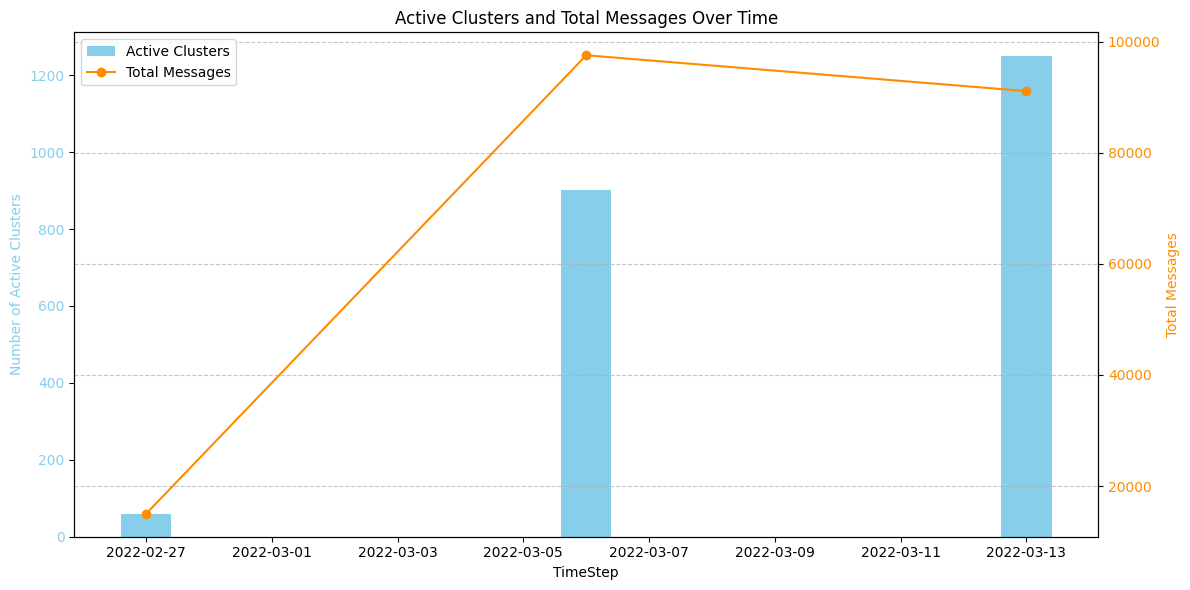

In [ ]:
minimum_messages_to_be_considered_active = 20
timestep_size = '1W'
analyze_and_plot_cluster_activity_messages(filtered_df, minimum_messages_to_be_considered_active, timestep_size)

#### Analyze Trending Clusters Each Week

In [ ]:
number_of_trending_clusters_to_show = 5
num_timesteps = 2
timestep_size = '1W'
similarity_threshold = 0.8
analyze_cluster_trends_new(filtered_df, number_of_trending_clusters_to_show,
                       min_start_date, num_timesteps, similarity_threshold=similarity_threshold, freq_given=timestep_size)

Defaulting to biggest clusters (no previous timestep to calculate growth):
  Cluster 31721: Count = 913

	- 2022-03-01 19:50:11: Cosine Distance = 0.0, 'AGENDA 03/01/22 from the telegram agency TelestreamMovement Soro Sorokov about mourning among Russian celebrities: “...The glamorous party is in mourning today.'

	- 2022-03-01 19:46:02: Cosine Distance = 0.0, 'AGENDA 03/01/22 from the telegram agency TelestreamMovement Soro Sorokov about mourning among Russian celebrities: “...The glamorous party is in mourning today.'

	Random 2 Rows from Cluster 31721:

	- 2022-03-05 05:37:52: Cosine Distance = 0.11457311794750202, 'Footage from the Kyiv region with the advancement of units of the Russian Armed Forces during a special military operation. Video of the Russian Ministry of Defense.'

	- 2022-03-03 07:37:16: Cosine Distance = 0.19020057275256952, 'Zelensky was captured near Volnovakha. 03/02/2022.'
  Cluster 36412: Count = 245

	- 2022-02-28 14:59:30: Cosine Distance = 0.0, 'I am amazed

### Analyze Large, Persistent Clusters

In [ ]:
number_of_trending_clusters_to_show = 5
num_timesteps = 2
timestep_size = '1W'
similarity_threshold = 0.8
analyze_cluster_trends_new_largest_themes(filtered_df, number_of_trending_clusters_to_show,
                       min_start_date, num_timesteps, similarity_threshold=similarity_threshold, freq_given=timestep_size)


Defaulting to biggest clusters:
  Cluster 31721: Count = 913

	- 2022-03-01 19:50:11: Cosine Distance = 0.0, 'AGENDA 03/01/22 from the telegram agency TelestreamMovement Soro Sorokov about mourning among Russian celebrities: “...The glamorous party is in mourning today.'

	- 2022-03-01 19:46:02: Cosine Distance = 0.0, 'AGENDA 03/01/22 from the telegram agency TelestreamMovement Soro Sorokov about mourning among Russian celebrities: “...The glamorous party is in mourning today.'

	Random 2 Rows from Cluster 31721:

	- 2022-03-04 10:46:46: Cosine Distance = 0.08528759529313179, 'Airborne Forces of the Russian Armed Forces in the suburbs of Kiev. Buchansky district.'

	- 2022-03-03 15:20:48: Cosine Distance = 0.19193834827931489, 'Subscriber: Kharkov. M. Kyiv, supermarket "Rost".'
  Cluster 36412: Count = 245

	- 2022-02-28 14:59:30: Cosine Distance = 0.0, 'I am amazed by your determination. I ask you to reach the end of your plans, at least for the sake of the people of Ukraine - my Moth

#### Find Persistent Clusters

Here, we find the most persistent clusters over the timesteps

We define persistence as a function of a cluster's size rank each timestep. For example, if a cluster is consistently the biggest cluster,
it will have the highest persistence score

In [ ]:
persistent_clusters = find_persistent_clusters(filtered_df, min_start_date,
                                               max_start_date+timedelta(weeks=1), freq_given='1W', n=50)
persistent_clusters

Cluster  Persistence_Score
82     20273           1.000000
50     25421           0.500000
83      4866           0.500000
0      31721           0.333333
84     46619           0.333333
..       ...                ...
48     33181           0.020408
123    17871           0.020408
49     36458           0.020000
81     23755           0.020000
124    18787           0.020000

[125 rows x 2 columns]

from matplotlib import pyplot as plt
persistent_clusters['Cluster'].plot(kind='hist', bins=20, title='Cluster')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
persistent_clusters['Persistence_Score'].plot(kind='hist', bins=20, title='Persistence_Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
persistent_clusters.plot(kind='scatter', x='Cluster', y='Persistence_Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
persistent_clusters['Cluster'].plot(kind='line', figsize=(8, 4), title='Cluster')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
persistent_clusters['Persistence_Score'].plot(kind='line', figsize=(8, 4), title='Persistence_Score')
plt.gca().spines[['top', 'right']].set_visible(False)

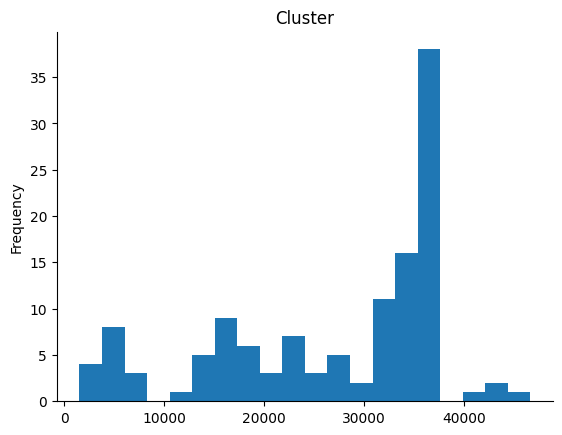

In [ ]:
# @title Cluster

from matplotlib import pyplot as plt
persistent_clusters['Cluster'].plot(kind='hist', bins=20, title='Cluster')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
top_most_persistent_to_analyze = 10
num_timesteps= 3
freq_given='1W'

analyze_persistent_clusters(filtered_df, persistent_clusters, min_start_date,
                            num_timesteps=num_timesteps, freq_given=freq_given, top_n=top_most_persistent_to_analyze)


Timestep 1: 2022-02-27 - 2022-03-06
Cluster 20273: Count = 5

	- 2022-03-04 07:25:55: Cosine Distance = 0.0, 'It is interesting that some time ago Israel itself strictly distanced itself from the need to react, weighing the risks for the Syrian theater of operations.'

	- 2022-03-04 04:07:33: Cosine Distance = 0.0, 'It is interesting that some time ago Israel itself strictly distanced itself from the need to react, weighing the risks for the Syrian theater of operations.'

	Random 2 Rows from Cluster 20273:

	- 2022-03-04 04:07:33: Cosine Distance = 0.0, 'It is interesting that some time ago Israel itself strictly distanced itself from the need to react, weighing the risks for the Syrian theater of operations.'

	- 2022-03-04 07:25:55: Cosine Distance = 0.0, 'It is interesting that some time ago Israel itself strictly distanced itself from the need to react, weighing the risks for the Syrian theater of operations.'
Cluster 25421: Count = 10

	- 2022-03-03 11:04:38: Cosine Distance = 0

#### Visualizations

Visualizes the interaction of unique cluster centroids within a specified date range, employing UMAP for dimensionality reduction to 2D space. Each point in the plot represents a cluster centroid, and these points are sized based on the scale of the cluster's size (number of messages in that timestep).


This visualization can be particularly insightful for exploring the clustering structure and dynamics over the selected period.

In [ ]:
# Example usage
# Assume 'df' has 'cluster_column' and 'centroid_column', where each centroid is stored as a numpy array
visualize_clusters_with_bokeh(filtered_df, min_start_date,
                              min_start_date+timedelta(weeks=1), '1W',
                              GLOBAL_CLUSTER_FIELD, GLOBAL_CENTROID_COLUMN, method='umap')

Processing timesteps:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## MacroCluster / Narrative Formation

Here, we then utilize the uncovered clusters as the stories that comprise a narrative.

We present how to form a MacroNarrative. Keep in mind that this portion is optional and requires a human-in-the-loop process.


Below we present the general methodology we follow.




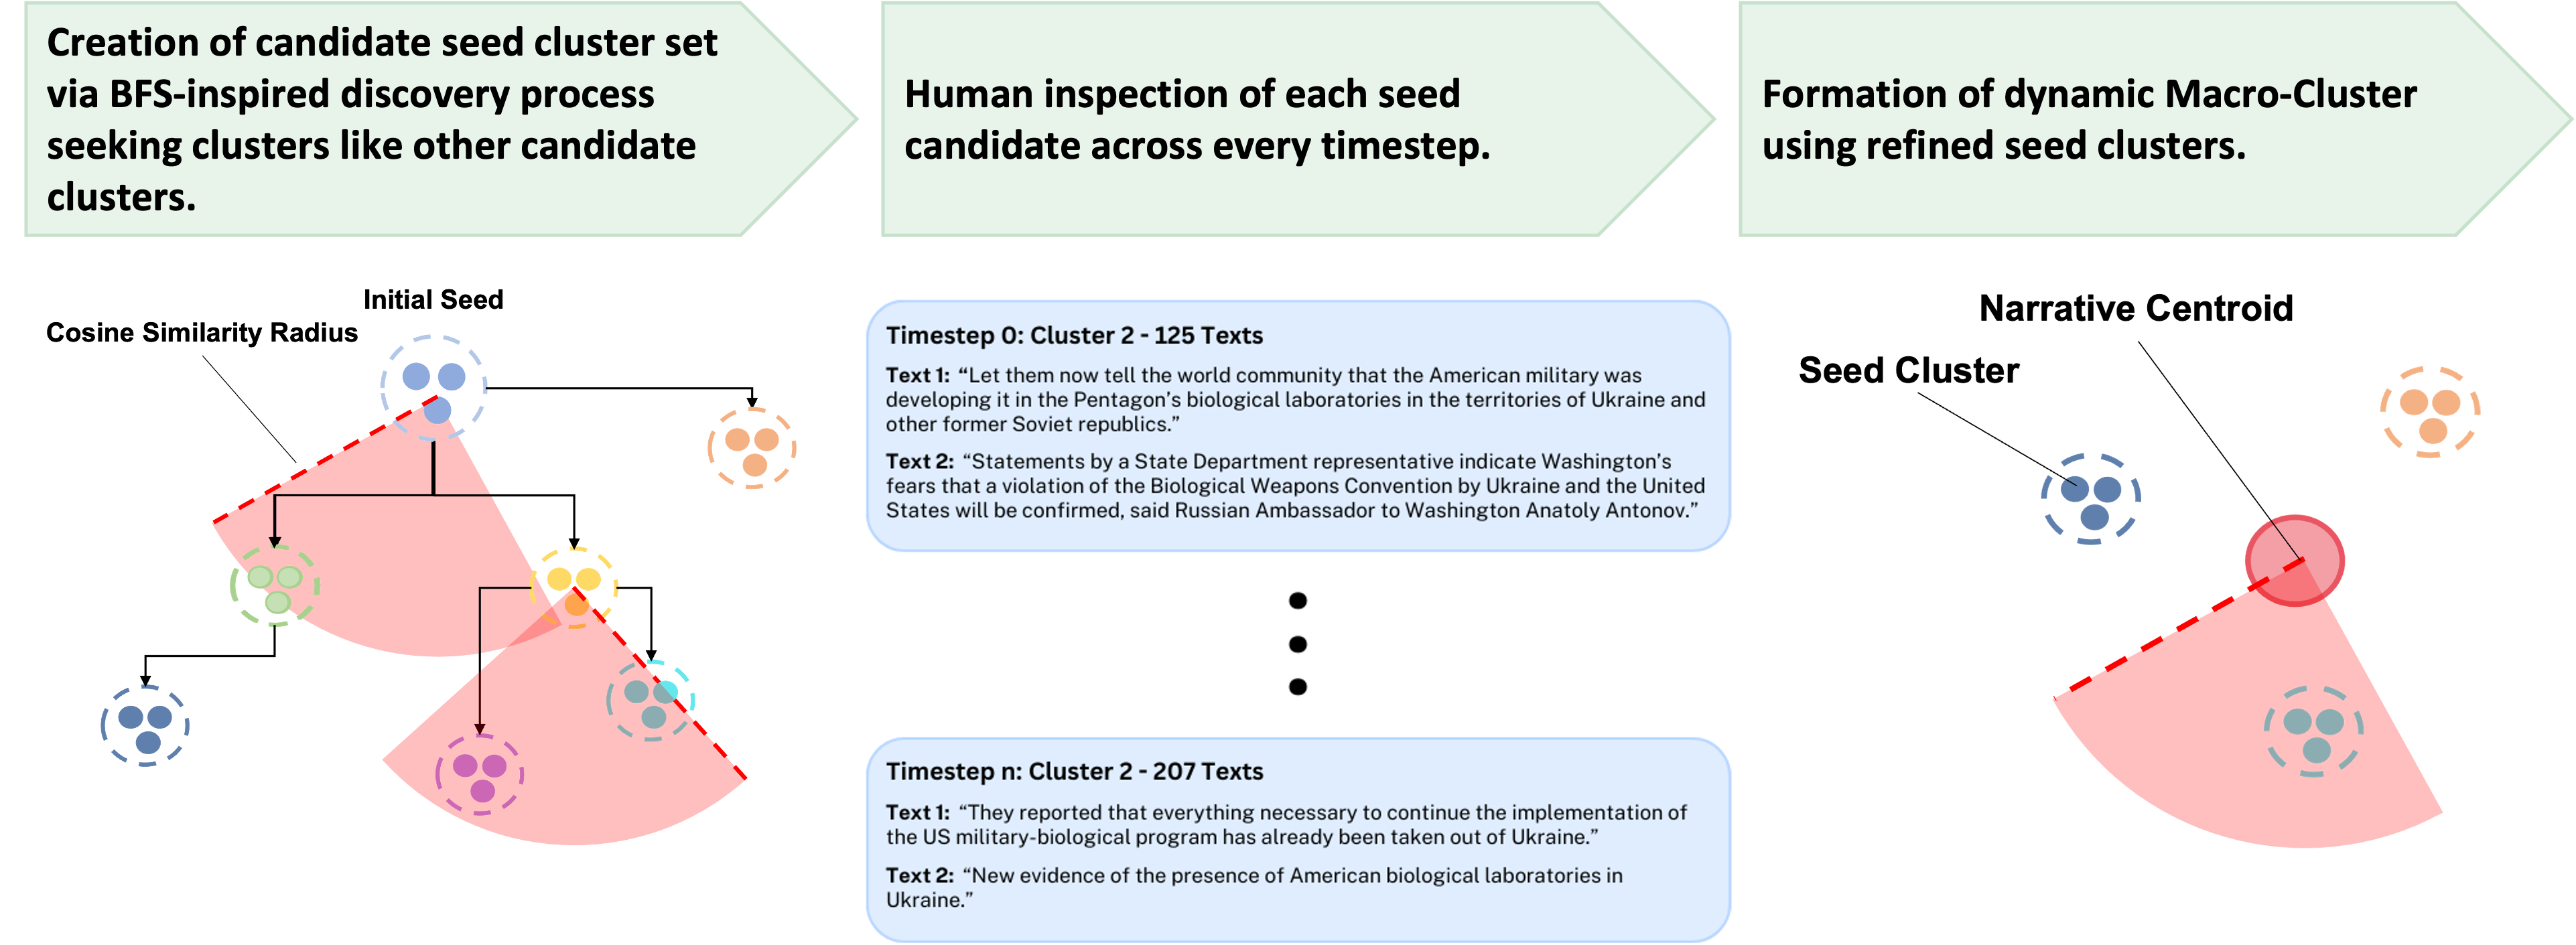

In [ ]:
class MacroCluster:
    def __init__(self, seed_clusters, min_similarity, dynamic_addition=False, min_dynamic_update_similarity=0.9, dynamic_addition_mode='grand_centroid'):
        self.seed_clusters = seed_clusters
        self.seed_clusters_set = set(seed_clusters)
        self.prev_grand_centroid = None
        self.current_grand_centroid = None
        self.min_similarity = min_similarity
        self.dynamic_addition = dynamic_addition
        self.min_dynamic_update_similarity = min_dynamic_update_similarity
        self.initialized = False
        self.prev_clusters = None
        self.current_clusters = {}
        self.dynamic_addition_mode = dynamic_addition_mode
        # self.prev_clusters_set = None
        # self.current_clusters_set = {}

    def update_centroid(self, df, centroid_column):
        # Retrieve the centroids for the seed clusters
        if self.dynamic_addition and self.initialized:
            if self.dynamic_addition_mode == 'grand_centroid':
                new_seeds = self.get_new_seeds(df, centroid_column)
            else:
                new_seeds = self.get_new_seeds_bfs(df, centroid_column)

            print(f"New Seeds: {new_seeds}")
            self.seed_clusters.extend(new_seeds)
            self.seed_clusters_set = set(self.seed_clusters)

        centroids = df[df['Cluster'].isin(self.seed_clusters)][centroid_column].to_list()
        self.initialized = True

        # Update prev_grand_centroid and calculate new current_grand_centroid
        self.prev_grand_centroid = self.current_grand_centroid
        self.current_grand_centroid = np.mean(np.stack(centroids), axis=0)

    def print_centroid_difference(self):
        if self.prev_grand_centroid is not None and self.current_grand_centroid is not None:
            distance = cosine(self.prev_grand_centroid, self.current_grand_centroid)
            print(f"Cosine distance between previous and current grand centroid: {distance:.4f}")
        else:
            print("Previous or current grand centroid is not available.")

    def get_new_seeds_bfs(self, df, centroid_column):
        similar_clusters = set()

        # Iterate over each seed cluster's centroid
        for seed_cluster in self.seed_clusters:
            seed_centroid = df.loc[df['Cluster'] == seed_cluster, centroid_column].iloc[0]

            # Compare with every other cluster
            for cluster in df['Cluster'].unique():
                if cluster not in self.seed_clusters_set:
                    cluster_centroid = df.loc[df['Cluster'] == cluster, centroid_column].iloc[0]
                    similarity = 1 - cosine(seed_centroid, cluster_centroid)

                    # Add cluster to the set if it meets the similarity threshold
                    if similarity >= self.min_dynamic_update_similarity:
                        similar_clusters.add(cluster)

        # Print each cluster and its cosine similarity
        for cluster in similar_clusters:
            cluster_centroid = df.loc[df['Cluster'] == cluster, centroid_column].iloc[0]
            similarities = [1 - cosine(seed_centroid, cluster_centroid) for seed_centroid in
                            df.loc[df['Cluster'].isin(self.seed_clusters), centroid_column]]
            max_similarity = max(similarities)
            print(f"Cluster {cluster}: Highest Cosine Similarity = {max_similarity:.4f}")

        return list(similar_clusters)


    def get_all_clusters(self, df, centroid_column):
        # Calculate cosine similarity with the current_grand_centroid for each cluster
        cluster_similarities = {}
        for cluster in df['Cluster'].unique():
            cluster_centroid = df.loc[df['Cluster'] == cluster, centroid_column].iloc[0]
            similarity = 1 - cosine(self.current_grand_centroid, cluster_centroid)
            if similarity >= self.min_similarity or cluster in self.seed_clusters_set:
                cluster_similarities[cluster] = similarity

        # Sort clusters by similarity
        sorted_clusters = sorted(cluster_similarities.items(), key=lambda x: x[1], reverse=True)

        # Print each cluster and its cosine similarity
        cluster_numbers = []
        for cluster, similarity in sorted_clusters:
            if cluster in self.seed_clusters_set:
                print(f"**Cluster {cluster}: Cosine Similarity = {similarity:.4f}")
            else:
                print(f"Cluster {cluster}: Cosine Similarity = {similarity:.4f}")
                cluster_numbers.append(cluster)

        new_current_clusters = {}
        for cluster, similarity in sorted_clusters:
            point_count = df[df['Cluster'] == cluster].shape[0]
            # centroid = df[df['Cluster'] == cluster]
            cluster_centroid = df.loc[df['Cluster'] == cluster, centroid_column].iloc[0]
            new_current_clusters[cluster] = {'similarity': similarity, 'point_count': point_count,
                                            'centroid': cluster_centroid}
        # Update prev_clusters and current_clusters
        self.prev_clusters = self.current_clusters
        self.current_clusters = new_current_clusters

        return cluster_numbers

    def get_new_seeds(self, df, centroid_column):
        # Calculate cosine similarity with the current_grand_centroid for each cluster
        cluster_similarities = {}
        for cluster in df['Cluster'].unique():
            cluster_centroid = df.loc[df['Cluster'] == cluster, centroid_column].iloc[0]
            similarity = 1 - cosine(self.current_grand_centroid, cluster_centroid)
            # print(f'similarity: {cluster} - {similarity}')
            if similarity >= self.min_dynamic_update_similarity:
                cluster_similarities[cluster] = similarity

        # Sort clusters by similarity
        sorted_clusters = sorted(cluster_similarities.items(), key=lambda x: x[1], reverse=True)
        # print(sorted_clusters)

        # Print each cluster and its cosine similarity
        cluster_numbers = []
        for cluster, similarity in sorted_clusters:
            if cluster not in self.seed_clusters_set:
                print(f'new cluster! {cluster}')
                cluster_numbers.append(cluster)

        return cluster_numbers


    def analyze_cluster_changes(self, top_n):
        if not self.prev_clusters or not self.current_clusters:
            print("Previous or current cluster data is not available.")
            return

        # Calculate growth and shrinkage for each cluster, excluding new clusters (infinity growth)
        growth_shrinkage_data = []
        new_clusters = []
        for cluster, current_data in self.current_clusters.items():
            prev_data = self.prev_clusters.get(cluster)
            if prev_data:
                point_growth = current_data['point_count'] - prev_data['point_count']
                percent_growth = (point_growth / prev_data['point_count']) * 100 if prev_data['point_count'] > 0 else 0
                growth_shrinkage_data.append((cluster, point_growth, percent_growth))
            else:
                new_clusters.append((cluster, current_data['point_count']))

        # Sort by percentage growth and shrinkage
        top_growing = sorted(growth_shrinkage_data, key=lambda x: x[2], reverse=True)[:top_n]
        top_shrinking = sorted(growth_shrinkage_data, key=lambda x: x[2])[:top_n]
        top_new_clusters = sorted(new_clusters, key=lambda x: x[1], reverse=True)[:top_n]

        # Print top growing and shrinking clusters
        print("Top Growing Clusters:")
        for cluster, growth, percent in top_growing:
            print(f"  Cluster {cluster}: Growth = {growth}, Percentage = {percent:.2f}%")

        print("Top Shrinking Clusters:")
        for cluster, shrinkage, percent in top_shrinking:
            print(f"  Cluster {cluster}: Shrinkage = {shrinkage}, Percentage = {percent:.2f}%")

        # Print top new clusters
        print("Top New Clusters:")
        for cluster, point_count in top_new_clusters:
            print(f"  Cluster {cluster}: New Points = {point_count}")
        # Total clusters and points growth
        total_prev_points = sum(data['point_count'] for data in self.prev_clusters.values())
        total_current_points = sum(data['point_count'] for data in self.current_clusters.values())
        total_cluster_growth = len(self.current_clusters) - len(self.prev_clusters)
        percent_cluster_growth = (total_cluster_growth / len(self.prev_clusters)) * 100 if len(self.prev_clusters) > 0 else float('inf')
        percent_points_growth = ((total_current_points - total_prev_points) / total_prev_points) * 100 if total_prev_points > 0 else float('inf')

        print(f"Total Cluster Growth: {total_cluster_growth} clusters, Percentage = {percent_cluster_growth:.2f}%")
        print(f"Total Points Growth: {total_current_points - total_prev_points} points, Percentage = {percent_points_growth:.2f}%")

        # Top clusters in terms of raw number of points
        top_clusters_raw_points = sorted(self.current_clusters.items(), key=lambda x: x[1]['point_count'], reverse=True)[:top_n]
        print("Top Clusters by Raw Number of Points:")
        for cluster, data in top_clusters_raw_points:
            print(f"  Cluster {cluster}: Points = {data['point_count']}")


    def summarize_current_state(self, top_n_dominant_clusters):
        if not self.current_clusters:
            print("Current cluster data is not available.")
            return

        # Total number of points
        total_points = sum(data['point_count'] for data in self.current_clusters.values())

        # Total number of clusters
        total_clusters = len(self.current_clusters)

        # Most dominant clusters by point count
        dominant_clusters = sorted(self.current_clusters.items(), key=lambda x: x[1]['point_count'], reverse=True)[:top_n_dominant_clusters]

        # Print summary
        print(f"Total Number of Points: {total_points}")
        print(f"Total Number of Clusters: {total_clusters}")
        print("Most Dominant Clusters:")
        most_dominant_clusters = []
        for cluster, data in dominant_clusters:
            print(f"  Cluster {cluster}: Points = {data['point_count']} - {(data['point_count']/total_points)*100:.3f}%")
            most_dominant_clusters.append(cluster)
        return most_dominant_clusters


#### Negotiations Starting Seeds

- Utilizing the persistent clusters, shown in the cells above as well as the visualization shown in the cells above, we can lock down what appears to be a persistent narrative. Keep in mind that this is done with 2 weeks for this example due to colab memory constraints, but ideally this would be done over many more timesteps

In [ ]:
starting_seed = 35233
similarity_threshold = 0.8
num_timesteps = 3

timestep_size = '1W'
starting_seeds = get_starting_seeds(filtered_df, starting_seed,
                                    similarity_threshold, min_start_date,
                                    num_timesteps, timestep_size)
starting_seeds

Cluster 35229.0: Similarity = 0.9359
Cluster 35225.0: Similarity = 0.9261
Cluster 27167.0: Similarity = 0.9214
Cluster 35265.0: Similarity = 0.9213
Cluster 35248.0: Similarity = 0.9195
Cluster 35235.0: Similarity = 0.9155
Cluster 35227.0: Similarity = 0.9141
Cluster 35228.0: Similarity = 0.9125
Cluster 35244.0: Similarity = 0.9099
Cluster 35232.0: Similarity = 0.9070
Cluster 35246.0: Similarity = 0.9025
Cluster 35198.0: Similarity = 0.9018
Cluster 35243.0: Similarity = 0.9018
Cluster 35231.0: Similarity = 0.9004
Cluster 35220.0: Similarity = 0.8987
Cluster 35234.0: Similarity = 0.8979
Cluster 35250.0: Similarity = 0.8943
Cluster 35230.0: Similarity = 0.8899
Cluster 35193.0: Similarity = 0.8885
Cluster 35209.0: Similarity = 0.8854
Cluster 36490.0: Similarity = 0.8814
Cluster 35242.0: Similarity = 0.8794
Cluster 35221.0: Similarity = 0.8771
Cluster 37263.0: Similarity = 0.8763
Cluster 28210.0: Similarity = 0.8758
Cluster 35210.0: Similarity = 0.8746
Cluster 35217.0: Similarity = 0.8738
C

[35201,
 35209,
 36490,
 35210,
 37263,
 35217,
 35220,
 35221,
 35223,
 35225,
 36377,
 35227,
 35228,
 35229,
 35230,
 35231,
 35232,
 35233,
 35234,
 35235,
 27167,
 35239,
 35242,
 35243,
 35244,
 35245,
 35246,
 35248,
 35249,
 35250,
 28210,
 35262,
 35264,
 35265,
 33618,
 35186,
 35190,
 35192,
 35193,
 35198]

#### Chemical Weapons Claims

In [ ]:
starting_seed = 25421
similarity_threshold = 0.85
num_timesteps = 3

timestep_size = '1W'
starting_seeds = get_starting_seeds(filtered_df, starting_seed,
                                    similarity_threshold, min_start_date,
                                    num_timesteps, timestep_size)
starting_seeds

Cluster 25420.0: Similarity = 0.8644
Cluster 25425.0: Similarity = 0.8558

--
Cluster 25420 - Timestep 0 - 2022-02-27 00:00:00:

	- 2022-03-01 07:52:48: Cosine Distance = 0.0, 'There are currently 16 US military biological laboratories operating on the territory of Ukraine. There is at least some information about nine of them, including the address and on the territory of which institution they are located.'

	- 2022-03-01 07:48:08: Cosine Distance = 0.0, 'There are currently 16 US military biological laboratories operating on the territory of Ukraine. There is at least some information about nine of them, including the address and on the territory of which institution they are located.'

	- 2022-03-01 07:51:11: Cosine Distance = 0.0, 'There are currently 16 US military biological laboratories operating on the territory of Ukraine. There is at least some information about nine of them, including the address and on the territory of which institution they are located.'

	Random 2 Rows f

[25425, 25420, 25421]

Utilize BFS-esque search algorithm for acquiring starting seeds for MacroCluster

In [ ]:
starting_seed = 25421
similarity_threshold = 0.83
num_timesteps = 3

timestep_size = '1W'
starting_seeds = get_starting_seeds_bfs(filtered_df, starting_seed,
                                    similarity_threshold, min_start_date,
                                    num_timesteps, timestep_size)


--
Cluster 25421 - Timestep 0 - 2022-02-27 08:01:20:
Cluster 25420.0: Similarity = 0.8644
Cluster 25425.0: Similarity = 0.8558
Cluster 36474.0: Similarity = 0.8407
Cluster 36361.0: Similarity = 0.8396
Cluster 33047.0: Similarity = 0.8326
Cluster 36356.0: Similarity = 0.8324
Cluster 36355.0: Similarity = 0.8316
Cluster 25418.0: Similarity = 0.8314

--
Cluster 25420 - Timestep 0 - 2022-02-27 08:01:20:

	- 2022-03-01 07:52:48: Cosine Distance = 0.0, 'There are currently 16 US military biological laboratories operating on the territory of Ukraine. There is at least some information about nine of them, including the address and on the territory of which institution they are located.'

	- 2022-03-01 07:48:08: Cosine Distance = 0.0, 'There are currently 16 US military biological laboratories operating on the territory of Ukraine. There is at least some information about nine of them, including the address and on the territory of which institution they are located.'

	- 2022-03-01 07:51:11: C

Now, using the gathered seeds, we will instantiate a MacroCluster class, using those seeds to guide it throughout time and taking in story clusters that fall within 0.9 similarity radius.

In [ ]:

min_similarity=0.9
min_dynamic_update_similarity=0.94

macro_cluster = MacroCluster(seed_clusters=starting_seeds, min_similarity=min_similarity, dynamic_addition=False,
                                  min_dynamic_update_similarity=min_dynamic_update_similarity, dynamic_addition_mode='bfs')


timesteps = 2
timestep_size = '1W'
weekly_data, macro_df_bioweapons_narrative = show_macro_cluster_evolution(min_start_date, timesteps,
                                                         filtered_df, macro_cluster,
                                                        timestep_size)